In [7]:
import os
os.listdir("/kaggle/input")


['augmented-alzheimer-mri-dataset-v2', 'imagesoasis']

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, ReLU, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical

np.random.seed(42)
tf.random.set_seed(42)

In [9]:
! kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset-v2

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2
License(s): GNU Lesser General Public License 3.0
augmented-alzheimer-mri-dataset-v2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
# Put on the same directory
from zipfile import ZipFile

# specifying the name of the zip file
file = "augmented-alzheimer-mri-dataset-v2.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    # list all the contents of the zip file
    zip.printdir()

    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
data/train/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg 2022-09-28 12:04:44        10725
data/train/MildDemented/000cdcc4-3e54-4034-a538-203c8047b564.jpg 2022-09-28 12:04:44        11122
data/train/MildDemented/0013ad52-8398-4892-9fde-060eb1ae956d.jpg 2022-09-28 12:04:44        10968
data/train/MildDemented/0015bdfc-2059-4195-8eff-9c5cf2e2c025.jpg 2022-09-28 12:04:44        11879
data/train/MildDemented/001f15e8-6ad4-4e7a-bc36-b62b984dad69.jpg 2022-09-28 12:04:44        11932
data/train/MildDemented/001f89e3-8207-4ee4-80d7-711c2acd191a.jpg 2022-09-28 12:04:44        10723
data/train/MildDemented/002cb9c1-b160-4c76-b7e4-5fb2f1b527f7.jpg 2022-09-28 12:04:44         9060
data/train/MildDemented/0033c404-4e68-438d-8312-ba5ba0100d46.jpg 2022-09-28 12:04:44        10511
data/train/MildDemented/00372fb8-22c8-4a67-8b10-564caed780fa.jpg 2022-09-28 12:04:44        10211
data/train/MildDemented/00387cfa-b6ce-

In [39]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import albumentations as A
import cv2
from glob import glob
from tqdm import tqdm
import numpy as np


def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)


def augment_data(read_path, save_path, category = None, augment=True):
    """ Performing data augmentation. """
    H = 128
    W = 128

    for img in os.listdir(read_path):
        """ Extracting the dir name and image name """

        image_path = os.path.join(read_path,img)
        name = img.split(".")[0]
        #print(image_path)


        """ Read the image """
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)

        augmentation_pipeline = A.Compose([

            # Padding and Cropping
            #A.PadIfNeeded(min_height=224, min_width=224, p=1.0),
            #A.RandomCrop(height=224, width=224, p=1.0)  # Randomly crop the image to 224x224

            # Geometric Transformations
            #A.HorizontalFlip(p=0.5),  # 50% chance of flipping the image left-right
            #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),  # Slight shift, scale, rotate

            # Elastic Deformation (Slight)
            #A.ElasticTransform(alpha=1, sigma=50, p=0.5),  # Mild elastic deformation

            # Brightness and Contrast Adjustments
            #A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.5, p=0.5),  # Adjust brightness and contrast
            ])

        X = [x]


        if (augment == True) and category == 'MildDemented':

            for _ in range(6):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])



        elif (augment == True) and category == 'ModerateDemented':

            for _ in range(100):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])



        elif (augment == True) and category == 'VeryMildDemented':

             for _ in range(2):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])



        elif (augment == True) and category == 'NonDemented':

             for _ in range(1):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])









        idx = 0
        for i in X:
            i = cv2.resize(i, (W, H))

            if len(X) == 1:  # each loop it will take one image
                tmp_image_name = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{idx}.jpg"

            image_path = os.path.join(save_path, tmp_image_name)

            cv2.imwrite(image_path, i)

            idx = idx + 1
        #break

In [40]:
""" Create New directory for images """

test_dir_path = "data/val/"
classes = []
classes = os.listdir(test_dir_path)



for i in range(len(classes)):
    create_dir(os.path.join("new_data/train",classes[i]))

for i in range(len(classes)):
    create_dir(os.path.join("new_data/test",classes[i]))

for i in range(len(classes)):
    create_dir(os.path.join("new_data/val",classes[i]))

for i in range(len(classes)):
    create_dir(os.path.join("new_data/Aug_train",classes[i]))

In [41]:
for i in range(len(classes)):
    augment_data(os.path.join(test_dir_path,classes[i]),
             os.path.join("new_data/test",classes[i]),augment=False)

In [42]:
dir_path = "data/train/"
classes = []
classes = os.listdir(dir_path)
print(classes)

['ModerateDemented', 'VeryMildDemented', 'MildDemented', 'NonDemented']


In [43]:
NonDemented = os.listdir("data/train/NonDemented")
print(len(NonDemented))

MildDemented = os.listdir("data/train/MildDemented")
print(len(MildDemented))

VeryMildDemented = os.listdir("data/train/VeryMildDemented")
print(len(VeryMildDemented))

ModerateDemented = os.listdir("data/train/ModerateDemented")
print(len(ModerateDemented))

9600
8960
8960
6464


In [44]:
import random
np.random.seed(42)
test_size = 0.2

val_of_NonDemented = random.sample(range(0, len(NonDemented)), int(test_size*len(NonDemented)))
val_of_MildDemented = random.sample(range(0, len(MildDemented)), int(test_size*len(MildDemented)))
val_of_VeryMildDemented = random.sample(range(0, len(VeryMildDemented)), int(test_size*len(VeryMildDemented)))
val_of_ModerateDemented = random.sample(range(0, len(ModerateDemented)), int(test_size*len(ModerateDemented)))

train_of_NonDemented = [num for num in range(0, len(NonDemented)) if num not in val_of_NonDemented]
train_of_MildDemented = [num for num in range(0, len(MildDemented)) if num not in val_of_MildDemented]
train_of_VeryMildDemented = [num for num in range(0, len(VeryMildDemented)) if num not in val_of_VeryMildDemented]
train_of_ModerateDemented = [num for num in range(0, len(ModerateDemented)) if num not in val_of_ModerateDemented]

In [45]:
print(len(val_of_NonDemented))
print(len(val_of_MildDemented))
print(len(val_of_VeryMildDemented))
print(len(val_of_ModerateDemented))

print(len(train_of_NonDemented))
print(len(train_of_MildDemented))
print(len(train_of_VeryMildDemented))
print(len(train_of_ModerateDemented))

1920
1792
1792
1292
7680
7168
7168
5172


In [46]:
def move_images(idx_list,read_path,write_path,data):
    for idx in idx_list:
        image_path = os.path.join(read_path,data[idx])
        name = data[idx]
        x = cv2.imread(image_path,cv2.IMREAD_COLOR)
        x = cv2.resize(x, (128, 128))

        image_write_path = os.path.join(write_path, name)
        cv2.imwrite(image_write_path, x)

In [47]:
move_images(val_of_NonDemented,'data/train/NonDemented','new_data/val/NonDemented',NonDemented)
move_images(val_of_MildDemented,'data/train/MildDemented','new_data/val/MildDemented',MildDemented)
move_images(val_of_VeryMildDemented,'data/train/VeryMildDemented','new_data/val/VeryMildDemented',VeryMildDemented)
move_images(val_of_ModerateDemented,'data/train/ModerateDemented','new_data/val/ModerateDemented',ModerateDemented)

In [48]:
print(len(os.listdir('new_data/val/NonDemented')),
len(os.listdir('new_data/val/MildDemented')),
len(os.listdir('new_data/val/VeryMildDemented')),
len(os.listdir('new_data/val/ModerateDemented')))

3467 3238 3202 2342


In [49]:
move_images(train_of_NonDemented,'data/train/NonDemented','new_data/train/NonDemented',NonDemented)
move_images(train_of_MildDemented,'data/train/MildDemented','new_data/train/MildDemented',MildDemented)
move_images(train_of_VeryMildDemented,'data/train/VeryMildDemented','new_data/train/VeryMildDemented',VeryMildDemented)
move_images(train_of_ModerateDemented,'data/train/ModerateDemented','new_data/train/ModerateDemented',ModerateDemented)

In [50]:
print(len(os.listdir('new_data/train/NonDemented')),
len(os.listdir('new_data/train/MildDemented')),
len(os.listdir('new_data/train/VeryMildDemented')),
len(os.listdir('new_data/train/ModerateDemented')))

9227 8614 8578 6222


In [51]:
""" Move images to the new directory and augment (optional)"""

augment_data("new_data/train/VeryMildDemented",
             "new_data/Aug_train/VeryMildDemented",category = 'VeryMildDemented',augment=False)

print(len(os.listdir("new_data/Aug_train/VeryMildDemented")))

8578


In [52]:
augment_data("new_data/train/NonDemented",
             "new_data/Aug_train/NonDemented",category = 'NonDemented',augment=False)

print(len(os.listdir("new_data/Aug_train/NonDemented")))

9227


In [53]:
augment_data("new_data/train/MildDemented",
             "new_data/Aug_train/MildDemented",category = 'MildDemented',augment=False)

print(len(os.listdir("new_data/Aug_train/MildDemented")))

8614


In [54]:
augment_data("new_data/train/ModerateDemented",
             "new_data/Aug_train/ModerateDemented",category = 'ModerateDemented',augment=False)

print(len(os.listdir("new_data/Aug_train/ModerateDemented")))

6222


In [55]:

train_path = r'new_data/Aug_train/'
val_path = r'new_data/val/'
test_path = r'new_data/test/'


train_datagen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1/255.0)

test_datagen = ImageDataGenerator(rescale = 1/255.0)


train_batches = train_datagen.flow_from_directory(directory = train_path,
                target_size = (128,128), batch_size = 32, class_mode='categorical', shuffle=True)

valid_batches = val_datagen.flow_from_directory(directory = val_path,
                target_size = (128,128), batch_size = 32, class_mode='categorical', shuffle=False)

test_batches = test_datagen.flow_from_directory(directory = test_path,
                target_size = (128,128), batch_size = 32, class_mode='categorical', shuffle=False)


Found 32641 images belonging to 4 classes.
Found 12249 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [56]:
base_model = tf.keras.applications.ResNet101(input_shape=(128,128,3),
                   include_top=False,
                   weights='imagenet')
base_model.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 42,552,832 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [57]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

In [58]:
model = Model(inputs=base_model.input, outputs=output)

In [59]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=categorical_crossentropy, metrics=['accuracy','recall', 'precision'])

In [60]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 44,760,452 (170.75 MB)

 Trainable params: 44,655,108 (170.35 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [61]:
from tensorflow.keras import backend as K

class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Clear TensorFlow session to free up memory
        K.clear_session()
        print(f"Cleared memory after epoch {epoch + 1}")


clear_memory = ClearMemory()

In [62]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Alzheimer/best_model_Aug_version.keras',       # Path to save model
    monitor='val_loss',             # Monitor validation loss
    save_best_only=True,            # Save only if the model does better
    mode='min',                     # Want to minimize the loss
    verbose=1,
)

In [63]:
# Define a custom learning rate decay function
def exponential_decay(epoch, lr):
    decay_rate = 0.96  # Decay by 4% each epoch
    return lr * decay_rate

# Create the LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_decay)

In [64]:
from sklearn.utils import class_weight
import numpy as np
zip = __builtins__.zip


# Define the class distribution
class_counts = {
    0: 2048,  # Non Demented
    1: 574,   # Mild Demented
    2: 1434,  # Very Mild Demented
    3: 42     # Moderate Demented
}

# Calculate class weights using the class_weight utility from sklearn
class_labels = np.array(list(class_counts.keys()))
sample_counts = np.array(list(class_counts.values()))
class_weights = class_weight.compute_class_weight('balanced', classes=class_labels, y=np.repeat(class_labels, sample_counts))

# Create a dictionary mapping class labels to weights
class_weight_dict = dict(zip(class_labels, class_weights))
print(class_weight_dict)

{0: 0.500244140625, 1: 1.7848432055749128, 2: 0.7144351464435147, 3: 24.392857142857142}


In [31]:
'''
model.fit(x = train_batches,
          validation_data = valid_batches,
          epochs=30,class_weight=class_weight_dict)
'''
history = model.fit(train_batches,
          validation_data = valid_batches,
          batch_size = 32,
          callbacks=[clear_memory, checkpoint_callback, lr_callback],
          epochs=20)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1766517102.659759     128 service.cc:145] XLA service 0x7f4e140028b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766517102.659824     128 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766517102.659828     128 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766517140.275707     128 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_53', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers a

850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6329 - loss: 0.8203 - precision: 0.7032 - recall: 0.5391Cleared memory after epoch 1

Epoch 1: val_loss improved from inf to 0.63368, saving model to /content/drive/MyDrive/Alzheimer/best_model_Aug_version.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 319s 267ms/step - accuracy: 0.6330 - loss: 0.8201 - precision: 0.7033 - recall: 0.5392 - val_accuracy: 0.7313 - val_loss: 0.6337 - val_precision: 0.7770 - val_recall: 0.6661 - learning_rate: 9.6000e-05
Epoch 2/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8829 - loss: 0.2902 - precision: 0.8951 - recall: 0.8724Cleared memory after epoch 2

Epoch 2: val_loss did not improve from 0.63368
850/850 ━━━━━━━━━━━━━━━━━━━━ 195s 220ms/step - accuracy: 0.8829 - loss: 0.2902 - precision: 0.8951 - recall: 0.8725 - val_accuracy: 0.7781 - val_loss: 0.7608 - val_precision: 0.7828 - val_recall: 0.7721 - learning_rate: 9.2160e-05
Epoch 3/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.

/tmp/ipykernel_25/2215440551.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 3)
/tmp/ipykernel_25/2215440551.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 4)


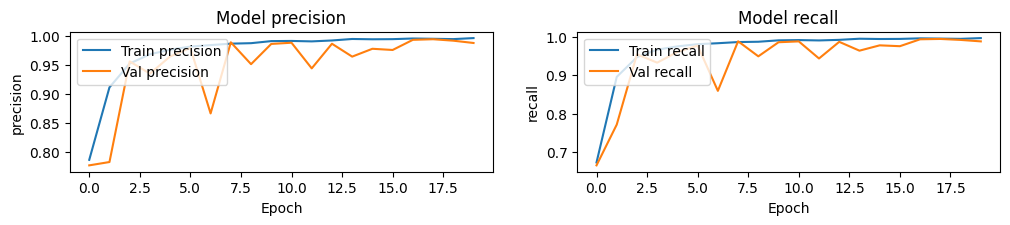

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('VGG16 - Accuracy')
# Plot precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train precision')
plt.plot(history.history['val_precision'], label='Val precision')
plt.title('Model precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend(loc='upper left')

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train recall')
plt.plot(history.history['val_recall'], label='Val recall')
plt.title('Model recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend(loc='upper left')

plt.show()

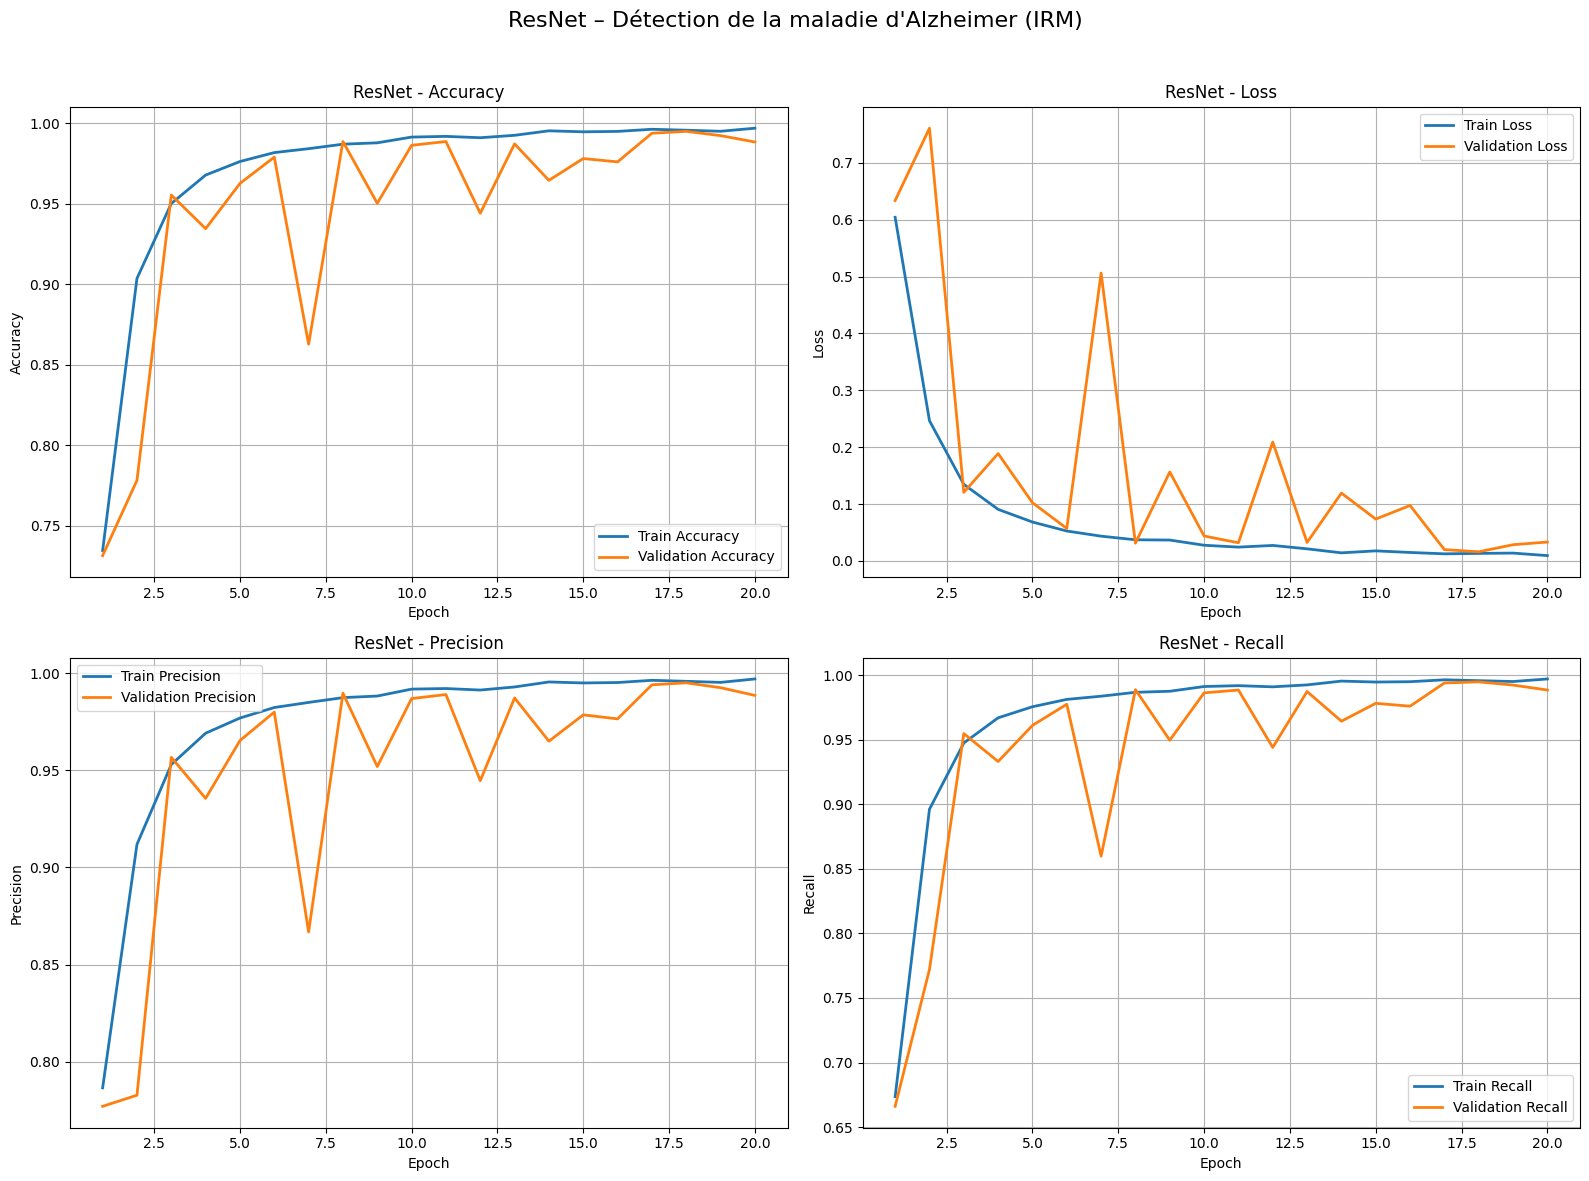

In [33]:
import matplotlib.pyplot as plt

H = history.history
epochs = range(1, len(H['loss']) + 1)

plt.figure(figsize=(16, 12))

# ---------- ACCURACY ----------
if 'accuracy' in H:
    plt.subplot(2, 2, 1)
    plt.plot(epochs, H['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(epochs, H['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('ResNet - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# ---------- LOSS ----------
plt.subplot(2, 2, 2)
plt.plot(epochs, H['loss'], label='Train Loss', linewidth=2)
plt.plot(epochs, H['val_loss'], label='Validation Loss', linewidth=2)
plt.title('ResNet - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ---------- PRECISION ----------
if 'precision' in H:
    plt.subplot(2, 2, 3)
    plt.plot(epochs, H['precision'], label='Train Precision', linewidth=2)
    plt.plot(epochs, H['val_precision'], label='Validation Precision', linewidth=2)
    plt.title('ResNet - Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

# ---------- RECALL ----------
if 'recall' in H:
    plt.subplot(2, 2, 4)
    plt.plot(epochs, H['recall'], label='Train Recall', linewidth=2)
    plt.plot(epochs, H['val_recall'], label='Validation Recall', linewidth=2)
    plt.title('ResNet - Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

plt.suptitle("ResNet – Détection de la maladie d'Alzheimer (IRM)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [34]:
# Sauvegarde du modèle dans /kaggle/working
model.save("/kaggle/working/best_model.h5")

# Récupérer les labels de test
test_labels = test_batches.classes
len(test_labels)


6400

In [35]:
preds = model.predict(x=test_batches,verbose=0)

In [36]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = preds.argmax(axis=1))
cm

array([[ 840,    0,   15,   41],
       [   0,   64,    0,    0],
       [   2,    0, 3100,   98],
       [   2,    0,  112, 2126]])

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# ===============================
# 1️⃣ Reset du générateur
# ===============================
test_batches.reset()

# ===============================
# 2️⃣ Prédictions du modèle
# ===============================
preds = model.predict(test_batches, verbose=1)

# ===============================
# 3️⃣ Labels réels et prédits
# ===============================
y_true = test_batches.classes
y_pred = np.argmax(preds, axis=1)

# Noms des classes
class_names = list(test_batches.class_indices.keys())

# ===============================
# 4️⃣ Matrice de confusion
# ===============================
cm = confusion_matrix(y_true, y_pred)

# Normalisation (optionnelle mais recommandée)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step


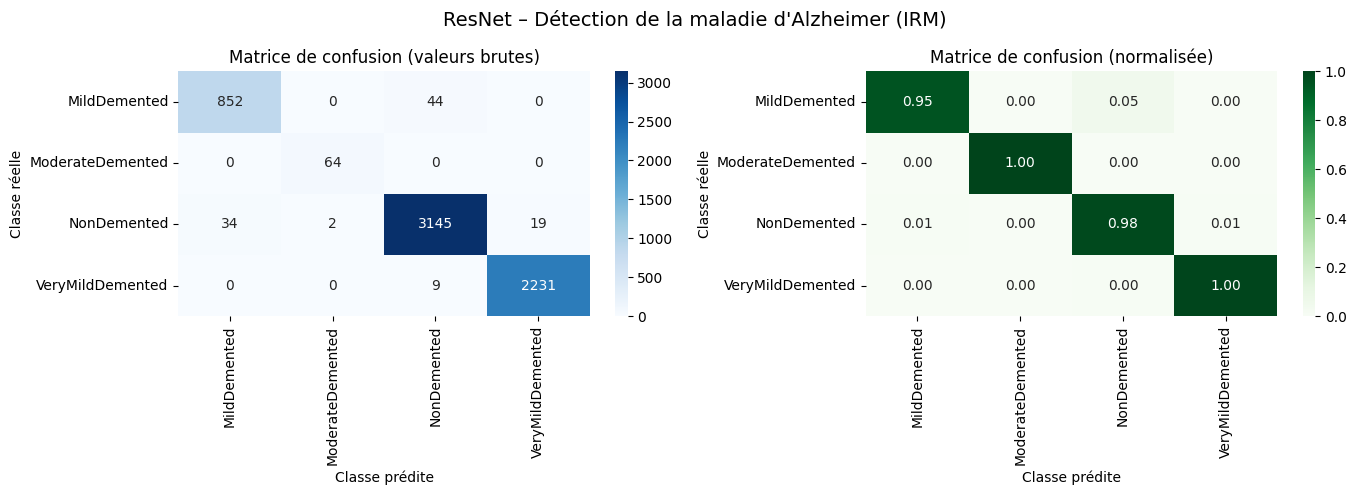

In [82]:
plt.figure(figsize=(14, 5))

# ---- Matrice brute ----
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Matrice de confusion (valeurs brutes)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

# ---- Matrice normalisée ----
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Matrice de confusion (normalisée)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.suptitle("ResNet – Détection de la maladie d'Alzheimer (IRM)", fontsize=14)
plt.tight_layout()
plt.show()


In [83]:
loss, accuracy, recall, pre = model.evaluate(test_batches)
print(f'Loss: {loss}, Accuracy: {accuracy}, recall: {recall}, precision: {pre} ')

200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9748 - loss: 0.0652 - precision: 0.9759 - recall: 0.9740
Loss: 0.044178348034620285, Accuracy: 0.9831249713897705, recall: 0.9838734865188599, precision: 0.9818750023841858 


In [84]:
import numpy as np
import tensorflow as tf
import cv2
import os

# ===================== CONFIGURATION =====================
CLASSIFICATION_MODEL = '/kaggle/working/best_modell.h5'
CLASS_SIZE = 128  # correspond à la taille attendue par le modèle

# Classes
CLASSES_4 = {
    0: 'Mild Dementia',
    1: 'Moderate Dementia', 
    2: 'Non Dementia',
    3: 'Very Mild Dementia'
}

# ===================== CHARGEMENT MODÈLE =====================
print(" Chargement du modèle de classification...")
class_model = tf.keras.models.load_model(CLASSIFICATION_MODEL)
print(" Modèle chargé !")

# ===================== CHARGEMENT IMAGE =====================
def load_image_for_classification(image_path):
    """Charge et prétraite l'image pour la classification"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f" Impossible de charger: {image_path}")
    
    # Redimensionner à 128x128 et convertir en RGB
    img_resized = cv2.resize(img, (CLASS_SIZE, CLASS_SIZE))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)
    img_rgb = img_rgb.astype(np.float32) / 255.0
    img_rgb = np.expand_dims(img_rgb, axis=0)  # Ajouter la dimension batch
    return img_rgb

# ===================== TEST DE CLASSIFICATION =====================
def test_classification(image_path):
    """Teste une image unique avec le modèle chargé"""
    img_input = load_image_for_classification(image_path)
    
    # Prédiction
    predictions = class_model.predict(img_input, verbose=0)
    class_idx = np.argmax(predictions[0])
    confidence = predictions[0][class_idx]
    class_name = CLASSES_4[class_idx]
    
    # Affichage des résultats
    print(f"\n IMAGE: {os.path.basename(image_path)}")
    print(f"   Classe prédite: {class_name}")
    print(f"   Confiance: {confidence*100:.2f}%")
    print("\n Probabilités pour toutes les classes:")
    for i in range(4):
        print(f"   {CLASSES_4[i]:20s}: {predictions[0][i]*100:.2f}%")
    
    return class_idx, predictions[0]

# ===================== EXEMPLE D'UTILISATION =====================
# Remplace ce chemin par l'image que tu veux tester
image_path = "/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0001_MR1_mpr-1_100.jpg"
test_classification(image_path)


 Chargement du modèle de classification...


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/best_modell.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [65]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_vgg16(input_shape=(128,128,3), num_classes=4, lr=1e-5):

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tuning : dégèle juste les 8 dernières couches
    base_model.trainable = True
    for layer in base_model.layers[:10]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy", "precision", "recall"]
    )

    return model


In [66]:
model = build_vgg16()
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,05

 Total params: 14,981,444 (57.15 MB)

 Trainable params: 13,244,932 (50.53 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

In [67]:
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    batch_size=32,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback, lr_callback]  
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1766525342.515210     138 service.cc:145] XLA service 0x7b9ef800b3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766525342.515296     138 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766525342.515309     138 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   2/1021 ━━━━━━━━━━━━━━━━━━━━ 1:41 100ms/step - accuracy: 0.1484 - loss: 15.3666 - precision: 0.0571 - recall: 0.0312         

I0000 00:00:1766525358.691047     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3648 - loss: 8.1610 - precision: 0.3954 - recall: 0.2662
Epoch 1: val_loss improved from inf to 1.94741, saving model to /content/drive/MyDrive/Alzheimer/best_model_Aug_version.keras
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 173s 150ms/step - accuracy: 0.3649 - loss: 8.1582 - precision: 0.3954 - recall: 0.2663 - val_accuracy: 0.4638 - val_loss: 1.9474 - val_precision: 0.4714 - val_recall: 0.4514 - learning_rate: 9.6000e-06
Epoch 2/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4855 - loss: 1.8474 - precision: 0.4945 - recall: 0.4658
Epoch 2: val_loss improved from 1.94741 to 1.83580, saving model to /content/drive/MyDrive/Alzheimer/best_model_Aug_version.keras
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 143s 139ms/step - accuracy: 0.4855 - loss: 1.8473 - precision: 0.4945 - recall: 0.4659 - val_accuracy: 0.5004 - val_loss: 1.8358 - val_precision: 0.5010 - val_recall: 0.4811 - learning_rate: 9.2160e-06
Epoch 3/20
1021/1021 ━━━━━━━━━━━━━━

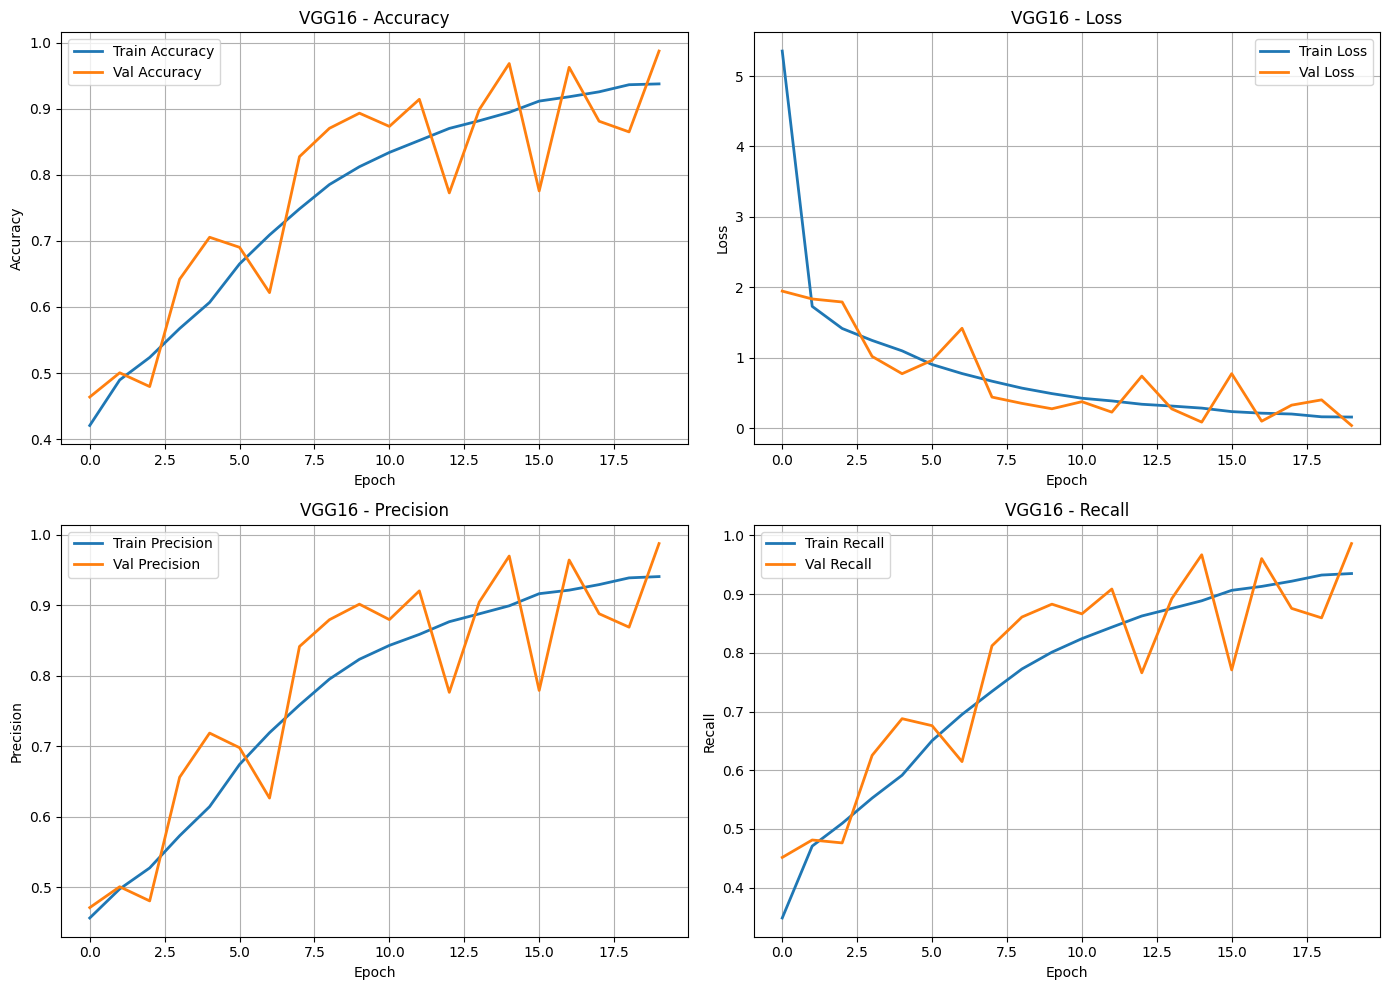

In [68]:
import matplotlib.pyplot as plt

# On utilise ton historique d'entraînement :
H = history.history

plt.figure(figsize=(14, 10))

# ---- ACCURACY ----
plt.subplot(2, 2, 1)
plt.plot(H['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(H['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('VGG16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ---- LOSS ----
plt.subplot(2, 2, 2)
plt.plot(H['loss'], label='Train Loss', linewidth=2)
plt.plot(H['val_loss'], label='Val Loss', linewidth=2)
plt.title('VGG16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ---- PRECISION ----
plt.subplot(2, 2, 3)
plt.plot(H['precision'], label='Train Precision', linewidth=2)
plt.plot(H['val_precision'], label='Val Precision', linewidth=2)
plt.title('VGG16 - Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# ---- RECALL ----
plt.subplot(2, 2, 4)
plt.plot(H['recall'], label='Train Recall', linewidth=2)
plt.plot(H['val_recall'], label='Val Recall', linewidth=2)
plt.title('VGG16 - Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [78]:
cm = confusion_matrix(
    y_true=test_batches.classes,
    y_pred=preds.argmax(axis=1)
)
cm


array([[ 852,    0,   44,    0],
       [   0,   64,    0,    0],
       [  34,    2, 3145,   19],
       [   0,    0,    9, 2231]])

In [79]:
# ===============================
# 1️⃣ Reset du générateur test
# ===============================
test_batches.reset()

# ===============================
# 2️⃣ Prédictions du modèle VGG16
# ===============================
preds = model.predict(test_batches, verbose=1)

# ===============================
# 3️⃣ Labels réels et prédits
# ===============================
y_true = test_batches.classes
y_pred = np.argmax(preds, axis=1)

# Noms des classes (ordre garanti)
class_names = list(test_batches.class_indices.keys())

# ===============================
# 4️⃣ Matrice de confusion
# ===============================
cm = confusion_matrix(y_true, y_pred)

# Normalisation par classe réelle
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)


200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step


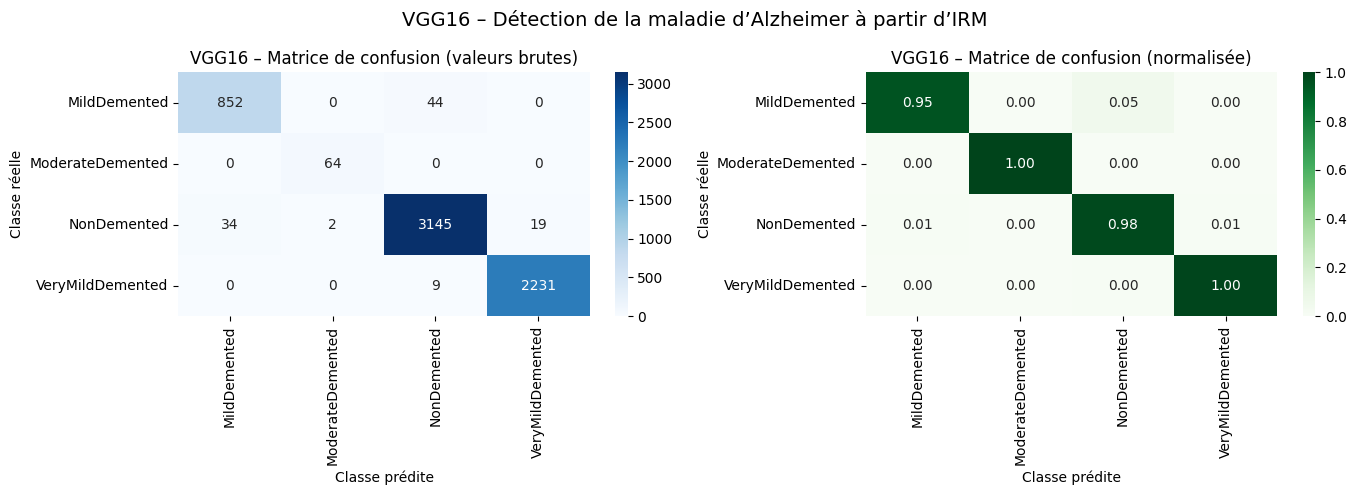

In [85]:
plt.figure(figsize=(14, 5))

# ---------- Matrice brute ----------
plt.subplot(1, 2, 1)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("VGG16 – Matrice de confusion (valeurs brutes)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

# ---------- Matrice normalisée ----------
plt.subplot(1, 2, 2)
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("VGG16 – Matrice de confusion (normalisée)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.suptitle(
    "VGG16 – Détection de la maladie d’Alzheimer à partir d’IRM",
    fontsize=14
)
plt.tight_layout()
plt.show()


In [72]:
results = model.evaluate(test_batches, return_dict=True)

print("\n🔵 VGG16 Evaluation Metrics:")
for k, v in results.items():
    print(f"{k:10s}: {v:.4f}")


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9748 - loss: 0.0652 - precision: 0.9759 - recall: 0.9740

🔵 VGG16 Evaluation Metrics:
accuracy  : 0.9831
loss      : 0.0442
precision : 0.9839
recall    : 0.9819


In [73]:
import os

print("Fichiers dans /kaggle/working :")
print(os.listdir("/kaggle/working"))


Fichiers dans /kaggle/working :
['new_data', 'data', '.virtual_documents', 'augmented-alzheimer-mri-dataset-v2.zip']


In [74]:
model.save("/kaggle/working/best_model_VGG16.h5")


In [76]:
model.save("/kaggle/working/best_model_VGG16.h5")
print("Modèle VGG16 sauvegardé avec succès !")


Modèle VGG16 sauvegardé avec succès !


In [86]:
import numpy as np
import tensorflow as tf
import cv2
import os

# ===================== CONFIGURATION =====================
CLASSIFICATION_MODEL = '/kaggle/working/best_model_VGG16.h5'  # modèle VGG16 sauvegardé
CLASS_SIZE = 128  # taille des images utilisées pour l'entraînement

# Classes du projet
CLASSES_4 = {
    0: 'Non Dementia',
    1: 'Mild Dementia',
    2: 'Moderate Dementia',
    3: 'Very Mild Dementia'
}

# ===================== CHARGEMENT DU MODÈLE =====================
print("Chargement du modèle VGG16...")
class_model = tf.keras.models.load_model(CLASSIFICATION_MODEL)
print("Modèle VGG16 chargé avec succès !")

# ===================== PRÉTRAITEMENT IMAGE =====================
def load_image_for_classification(image_path):
    """
    Charge et prétraite une image IRM pour la classification Alzheimer.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise FileNotFoundError(f"Impossible de charger l'image : {image_path}")

    # Redimensionner 128x128 et convertir en 3 canaux (RGB)
    img_resized = cv2.resize(img, (CLASS_SIZE, CLASS_SIZE))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)

    # Normalisation
    img_rgb = img_rgb.astype(np.float32) / 255.0

    # Ajout dimension batch
    img_rgb = np.expand_dims(img_rgb, axis=0)

    return img_rgb

# ===================== PRÉDICTION =====================
def test_classification(image_path):
    """
    Teste une image avec le modèle VGG16 et affiche les probabilités.
    """
    print(f"\n--- Test de l'image : {image_path} ---")

    img_input = load_image_for_classification(image_path)

    # Prédiction
    predictions = class_model.predict(img_input, verbose=0)
    class_idx = np.argmax(predictions[0])
    confidence = predictions[0][class_idx]

    class_name = CLASSES_4[class_idx]

    print(f"\nClasse prédite : {class_name}")
    print(f"Confiance : {confidence*100:.2f}%")

    print("\nProbabilités des classes :")
    for i in range(len(CLASSES_4)):
        print(f"  {CLASSES_4[i]:20s} : {predictions[0][i]*100:.2f}%")

    return class_idx, predictions[0]

# ===================== EXEMPLE D'UTILISATION =====================
image_path = "/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0001_MR1_mpr-1_100.jpg"
test_classification(image_path)


Chargement du modèle VGG16...
Modèle VGG16 chargé avec succès !

--- Test de l'image : /kaggle/input/imagesoasis/Data/Non Demented/OAS1_0001_MR1_mpr-1_100.jpg ---

Classe prédite : Non Dementia
Confiance : 99.98%

Probabilités des classes :
  Non Dementia         : 99.98%
  Mild Dementia        : 0.01%
  Moderate Dementia    : 0.01%
  Very Mild Dementia   : 0.00%


(0,
 array([9.9980909e-01, 7.7896533e-05, 8.4871943e-05, 2.8168519e-05],
       dtype=float32))

In [87]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

In [88]:
import os

BASE_DIR = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data"   

train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")

print("Train :", train_dir)
print("Val   :", val_dir)


Train : /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train
Val   : /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val


In [89]:
print("Classes TRAIN :", os.listdir(train_dir))
print("Classes VAL   :", os.listdir(val_dir))


Classes TRAIN : ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']
Classes VAL   : ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


In [90]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [91]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [92]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [93]:
def build_efficientnet(
    input_shape=(224,224,3),
    num_classes=4,
    lr=1e-4
):

    base_model = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    # Déblocage partiel (IMPORTANT)
    for layer in base_model.layers[:-100]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)

    output = Dense(num_classes, activation="softmax")(x)

    model = Model(base_model.input, output)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            Precision(name="precision"),
            Recall(name="recall")
        ]
    )

    return model


In [94]:
model_eff = build_efficientnet(
    input_shape=(224,224,3),
    num_classes=train_batches.num_classes
)

model_eff.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 3,809,656 (14.53 MB)

 Non-trainable params: 573,999 (2.19 MB)

In [95]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


In [96]:
classes = np.unique(train_batches.classes)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_batches.classes
)

class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)


{0: 0.9482142857142857, 1: 1.3143564356435644, 2: 0.885, 3: 0.9482142857142857}


In [97]:
print("Train samples :", train_batches.samples)
print("Val samples   :", val_batches.samples)
print("Class indices :", train_batches.class_indices)


Train samples : 33984
Val samples   : 6400
Class indices : {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [98]:
from tensorflow.keras.optimizers import Adam

model_eff.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],   
    run_eagerly=True       
)


In [99]:
history_eff = model_eff.fit(
    train_batches,
    validation_data=val_batches,
    epochs=5
)


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1181s 1s/step - accuracy: 0.5419 - loss: 1.2304 - val_accuracy: 0.6708 - val_loss: 0.7951
Epoch 2/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1149s 1s/step - accuracy: 0.7986 - loss: 0.4783 - val_accuracy: 0.8230 - val_loss: 0.4343
Epoch 3/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1176s 1s/step - accuracy: 0.8922 - loss: 0.2676 - val_accuracy: 0.8342 - val_loss: 0.4800
Epoch 4/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1160s 1s/step - accuracy: 0.9328 - loss: 0.1725 - val_accuracy: 0.9252 - val_loss: 0.2120
Epoch 5/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1166s 1s/step - accuracy: 0.9538 - loss: 0.1237 - val_accuracy: 0.9125 - val_loss: 0.2702


In [100]:
model_eff.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    run_eagerly=True
)


In [101]:
history_eff_ft = model_eff.fit(
    train_batches,
    validation_data=val_batches,
    epochs=10
)


Epoch 1/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1163s 1s/step - accuracy: 0.9715 - loss: 0.0780 - val_accuracy: 0.9486 - val_loss: 0.1389
Epoch 2/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1167s 1s/step - accuracy: 0.9775 - loss: 0.0601 - val_accuracy: 0.9486 - val_loss: 0.1493
Epoch 3/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1204s 1s/step - accuracy: 0.9760 - loss: 0.0641 - val_accuracy: 0.9522 - val_loss: 0.1379
Epoch 4/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1197s 1s/step - accuracy: 0.9820 - loss: 0.0528 - val_accuracy: 0.9572 - val_loss: 0.1190
Epoch 5/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1208s 1s/step - accuracy: 0.9824 - loss: 0.0484 - val_accuracy: 0.9544 - val_loss: 0.1249
Epoch 6/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1177s 1s/step - accuracy: 0.9837 - loss: 0.0461 - val_accuracy: 0.9638 - val_loss: 0.1065
Epoch 7/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1185s 1s/step - accuracy: 0.9856 - loss: 0.0394 - val_accuracy: 0.9581 - val_loss: 0.1238
Epoch 8/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1172s 1s/step - accuracy: 0.9862 -

In [102]:
import numpy as np
from sklearn.metrics import classification_report

val_batches.reset()
preds = model_eff.predict(val_batches)
y_pred = np.argmax(preds, axis=1)
y_true = val_batches.classes

print(classification_report(
    y_true,
    y_pred,
    target_names=list(val_batches.class_indices.keys())
))


200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 266ms/step
                  precision    recall  f1-score   support

    MildDemented       1.00      0.93      0.96       896
ModerateDemented       1.00      1.00      1.00        64
     NonDemented       0.95      0.99      0.97      3200
VeryMildDemented       0.98      0.94      0.96      2240

        accuracy                           0.97      6400
       macro avg       0.98      0.97      0.97      6400
    weighted avg       0.97      0.97      0.97      6400



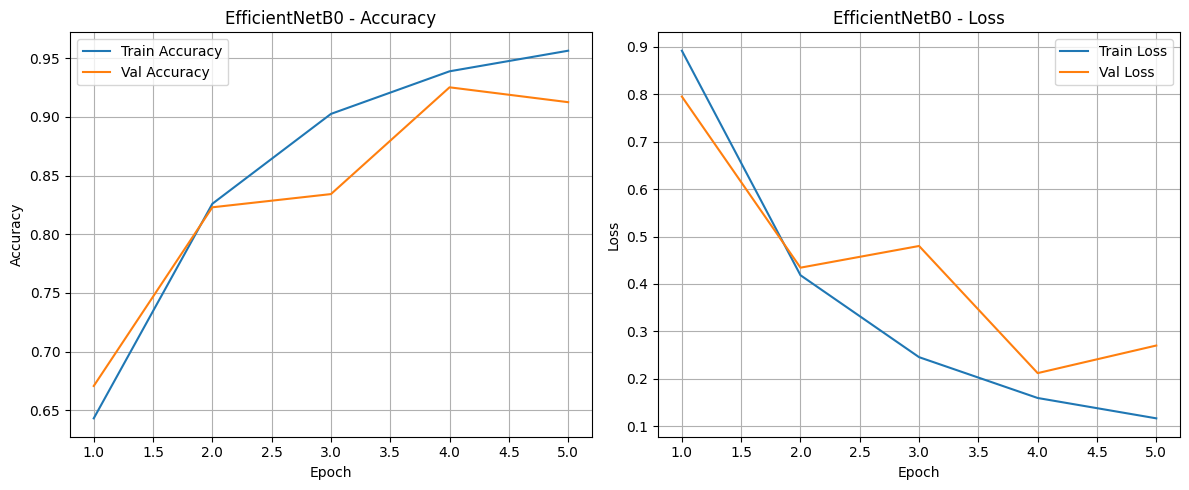

In [103]:
import matplotlib.pyplot as plt

H = history_eff.history
epochs = range(1, len(H["loss"]) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, H["accuracy"], label="Train Accuracy")
plt.plot(epochs, H["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("EfficientNetB0 - Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, H["loss"], label="Train Loss")
plt.plot(epochs, H["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EfficientNetB0 - Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [104]:
val_batches.reset()
preds = model_eff.predict(val_batches)

y_true = val_batches.classes
y_pred = np.argmax(preds, axis=1)

class_names = list(val_batches.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)


200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step


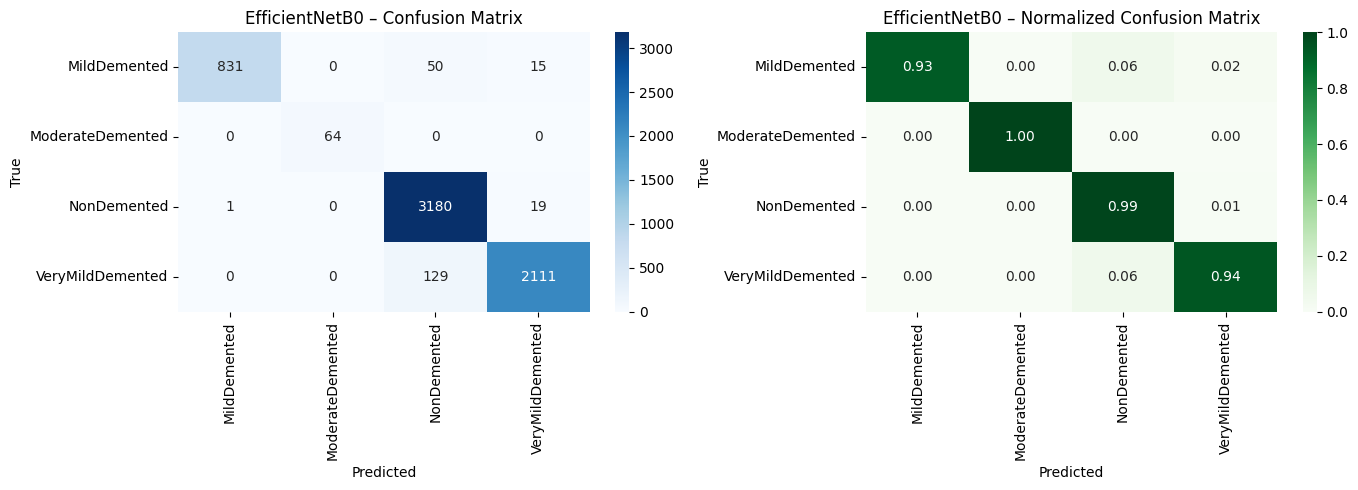

In [105]:
plt.figure(figsize=(14,5))

# Brute
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("EfficientNetB0 – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Normalisée
plt.subplot(1,2,2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("EfficientNetB0 – Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()


In [111]:
results = model_eff.evaluate(val_batches, return_dict=True)

print("\n🔵 EfficientNet – Evaluation Metrics:")
for k, v in results.items():
    print(f"{k:12s}: {v:.4f}")


200/200 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - accuracy: 0.9608 - loss: 0.1138

🔵 EfficientNet – Evaluation Metrics:
accuracy    : 0.9666
loss        : 0.0935


In [112]:
import os

print("Fichiers dans /kaggle/working :")
print(os.listdir("/kaggle/working"))


Fichiers dans /kaggle/working :
['new_data', 'data', '.virtual_documents', 'xai_brain_focused_nonDem278.jpg.png', 'xai_brain_focused_verymildDem102.jpg.png', 'xai_brain_focused_mildDem60.jpg.png', 'xai_brain_focused_moderateDem28.jpg.png', 'augmented-alzheimer-mri-dataset-v2.zip', 'best_model_VGG16.h5']


In [113]:
MODEL_SAVE_PATH = "/kaggle/working/best_model_EfficientNetB0.h5"

model_eff.save(MODEL_SAVE_PATH)
print("✅ Modèle EfficientNet sauvegardé avec succès !")


✅ Modèle EfficientNet sauvegardé avec succès !


In [114]:
MODEL_PATH = '/kaggle/working/best_model_EfficientNetB0.h5'
IMG_SIZE = (224, 224)


In [116]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.efficientnet import preprocess_input
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore


In [117]:
MODEL_PATH = "/kaggle/working/best_model_EfficientNetB0.h5"
DATA_PATH = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val"
IMG_SIZE = (224, 224)

CLASS_NAMES = [
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented"
]

model = keras.models.load_model(MODEL_PATH)
print("✓ Modèle EfficientNet chargé")


✓ Modèle EfficientNet chargé


In [118]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)

    # preprocess EfficientNet (OBLIGATOIRE)
    img_preprocessed = preprocess_input(img_array)

    img_batch = np.expand_dims(img_preprocessed, axis=0)
    return img, img_array, img_batch


In [119]:
def predict_image(model, img_batch):
    preds = model.predict(img_batch, verbose=0)[0]
    idx = np.argmax(preds)
    return idx, preds[idx], preds


In [120]:
def extract_brain_mask(img_array):
    gray = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask / 255.0


In [121]:
def apply_gradcam_efficientnet(model, img_batch, class_idx):
    layer_name = "block6a_expand_conv"  # couche recommandée EfficientNetB0
    print("Couche Grad-CAM :", layer_name)

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    gradcam = Gradcam(model, model_modifier=model_modifier, clone=True)
    cam = gradcam(
        CategoricalScore(class_idx),
        img_batch,
        penultimate_layer=layer_name
    )

    return cam[0]


In [122]:
def overlay_heatmap(img, heatmap, mask=None, alpha=0.5):
    img = np.array(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    if mask is not None:
        heatmap = heatmap * cv2.resize(mask, (img.shape[1], img.shape[0]))

    heatmap = heatmap / heatmap.max() if heatmap.max() > 0 else heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    return np.uint8(img * (1 - alpha) + heatmap * alpha)


In [123]:
def run_xai_efficientnet(img_path):
    print("\n" + "="*60)
    print("IMAGE :", os.path.basename(img_path))
    print("="*60)

    # 1️⃣ Charger image
    img, img_array, img_batch = load_and_preprocess_image(img_path)

    # 2️⃣ Masque cerveau
    brain_mask = extract_brain_mask(img_array)

    # 3️⃣ Prédiction
    pred_idx, conf, preds = predict_image(model, img_batch)
    print("Classe prédite :", CLASS_NAMES[pred_idx])
    print("Confiance :", f"{conf:.2%}")

    # 4️⃣ Grad-CAM
    gradcam_heatmap = apply_gradcam_efficientnet(model, img_batch, pred_idx)

    # 5️⃣ Ratio attention cerveau
    brain_attention = (gradcam_heatmap * brain_mask).sum()
    total_attention = gradcam_heatmap.sum()
    ratio = brain_attention / total_attention if total_attention > 0 else 0

    print(f"Attention cerveau : {ratio*100:.1f}%")
    print(f"Attention hors cerveau : {(1-ratio)*100:.1f}%")

    # 6️⃣ Visualisation
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(img)
    axs[0].set_title("Image originale")
    axs[0].axis("off")

    axs[1].imshow(brain_mask, cmap="gray")
    axs[1].set_title("Masque cerveau")
    axs[1].axis("off")

    axs[2].imshow(overlay_heatmap(img, gradcam_heatmap))
    axs[2].set_title("Grad-CAM global")
    axs[2].axis("off")

    axs[3].imshow(overlay_heatmap(img, gradcam_heatmap, brain_mask))
    axs[3].set_title("Grad-CAM focus cerveau")
    axs[3].axis("off")

    plt.show()

    return ratio



IMAGE : nonDem706.jpg
Classe prédite : NonDemented
Confiance : 99.91%
Couche Grad-CAM : block6a_expand_conv
Attention cerveau : 65.4%
Attention hors cerveau : 34.6%


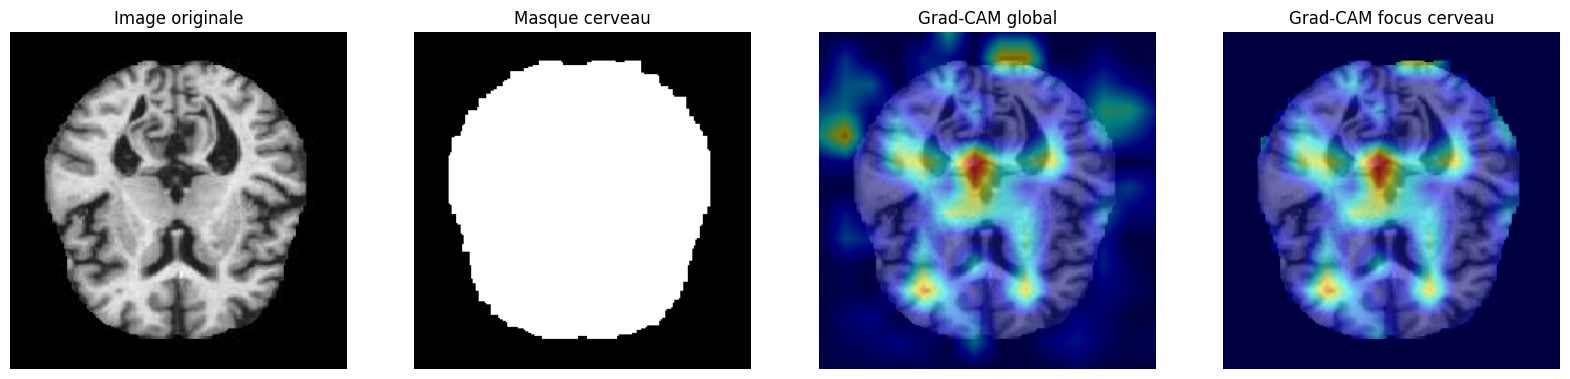

0.6540120523198472

In [124]:
# Choisir une image automatiquement
class_dir = os.path.join(DATA_PATH, "NonDemented")
img_name = [f for f in os.listdir(class_dir) if f.endswith(('.jpg','.png','.jpeg'))][0]
img_path = os.path.join(class_dir, img_name)

run_xai_efficientnet(img_path)



══════════════════════════════════════════════════════════════════════
CLASSE : MildDemented
══════════════════════════════════════════════════════════════════════

IMAGE : mildDem412.jpg
Classe prédite : MildDemented
Confiance : 99.81%
Couche Grad-CAM : block6a_expand_conv
Attention cerveau : 73.3%
Attention hors cerveau : 26.7%


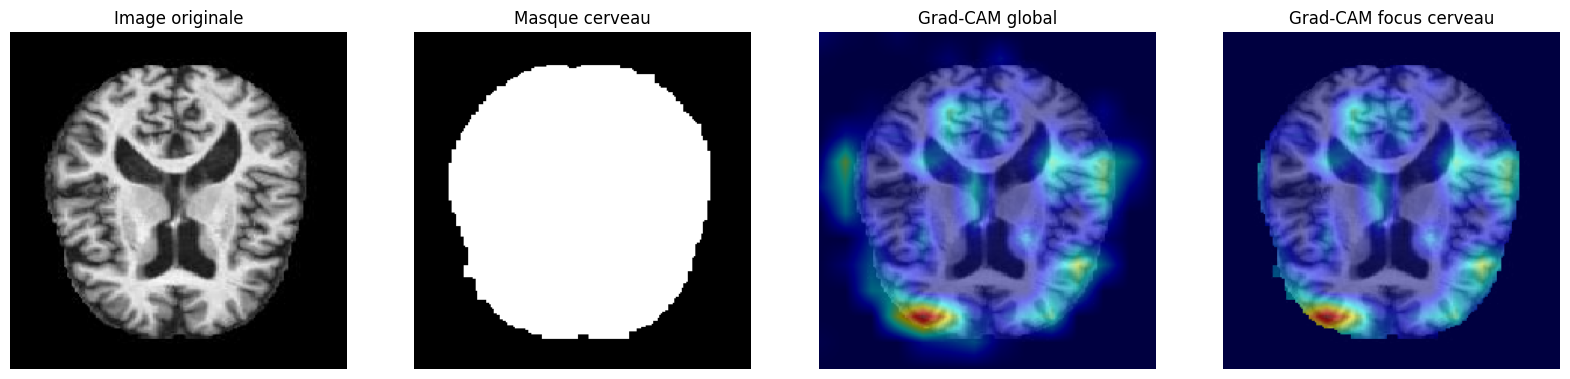


══════════════════════════════════════════════════════════════════════
CLASSE : ModerateDemented
══════════════════════════════════════════════════════════════════════

IMAGE : moderateDem40.jpg
Classe prédite : ModerateDemented
Confiance : 100.00%
Couche Grad-CAM : block6a_expand_conv
Attention cerveau : 57.6%
Attention hors cerveau : 42.4%


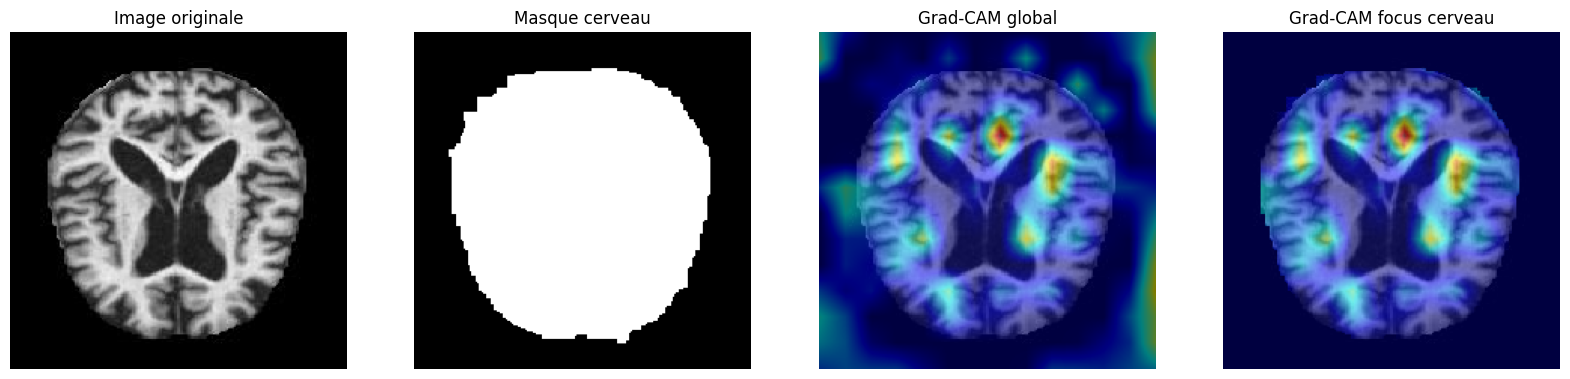


══════════════════════════════════════════════════════════════════════
CLASSE : NonDemented
══════════════════════════════════════════════════════════════════════

IMAGE : nonDem706.jpg
Classe prédite : NonDemented
Confiance : 99.91%
Couche Grad-CAM : block6a_expand_conv
Attention cerveau : 65.4%
Attention hors cerveau : 34.6%


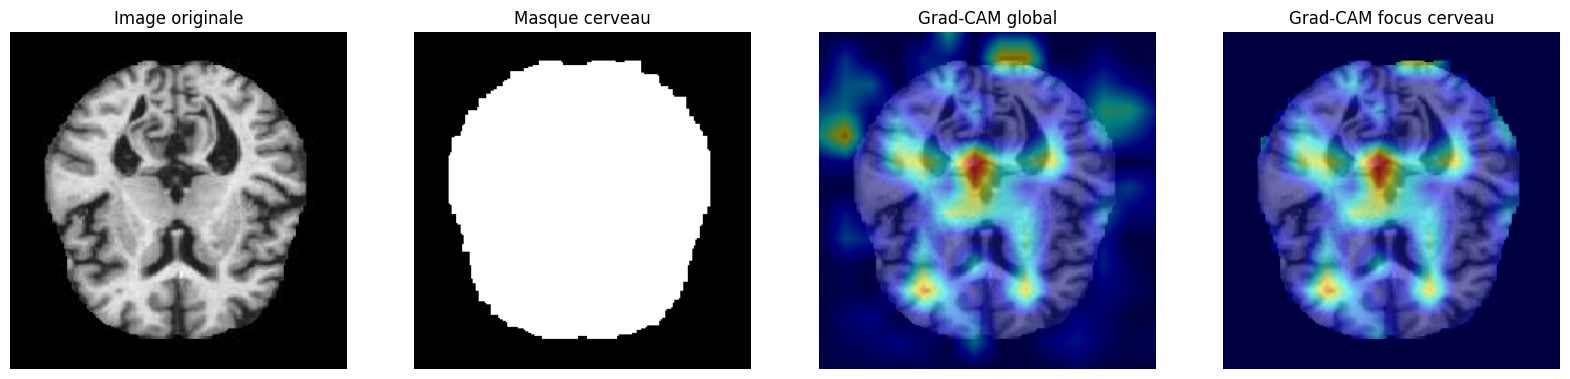


══════════════════════════════════════════════════════════════════════
CLASSE : VeryMildDemented
══════════════════════════════════════════════════════════════════════

IMAGE : verymildDem1202.jpg
Classe prédite : VeryMildDemented
Confiance : 99.99%
Couche Grad-CAM : block6a_expand_conv
Attention cerveau : 47.3%
Attention hors cerveau : 52.7%


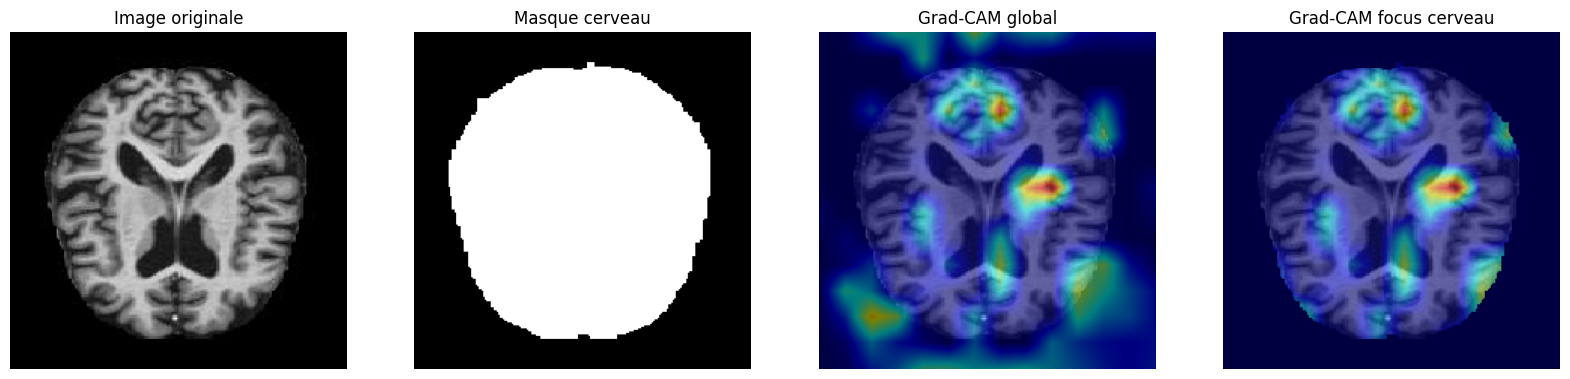

In [125]:
# ===============================
# XAI EfficientNet sur TOUTES les classes
# ===============================

for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATA_PATH, class_name)

    if not os.path.exists(class_dir):
        print(f"❌ Classe non trouvée : {class_name}")
        continue

    images = [f for f in os.listdir(class_dir) 
              if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(images) == 0:
        print(f"❌ Aucune image pour : {class_name}")
        continue

    # Prendre la première image
    img_path = os.path.join(class_dir, images[0])

    print("\n" + "═"*70)
    print(f"CLASSE : {class_name}")
    print("═"*70)

    run_xai_efficientnet(img_path)


In [106]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


                  precision    recall  f1-score   support

    MildDemented     0.9988    0.9275    0.9618       896
ModerateDemented     1.0000    1.0000    1.0000        64
     NonDemented     0.9467    0.9938    0.9697      3200
VeryMildDemented     0.9841    0.9424    0.9628      2240

        accuracy                         0.9666      6400
       macro avg     0.9824    0.9659    0.9736      6400
    weighted avg     0.9676    0.9666    0.9665      6400



In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
def grad_cam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
# Récupérer une image depuis val_batches
img_batch, label_batch = next(valid_batches)

img = img_batch[0]
img_array = np.expand_dims(img, axis=0)


CHARGEMENT DU MODÈLE
✓ Modèle chargé

ANALYSE XAI AVEC FOCUS SUR LE CERVEAU

──────────────────────────────────────────────────────────────────────
Classe: MildDemented
──────────────────────────────────────────────────────────────────────

ANALYSE XAI: mildDem60.jpg

📊 PRÉDICTION:
  • Classe: MildDemented
  • Confiance: 99.74%

  Probabilités:
    MildDemented: 99.74%
    ModerateDemented: 0.01%
    NonDemented: 0.18%
    VeryMildDemented: 0.07%

🔍 APPLICATION XAI:

1. Grad-CAM...
  → Couche: block5_conv3

2. Grad-CAM++...
  → Couche: block5_conv3


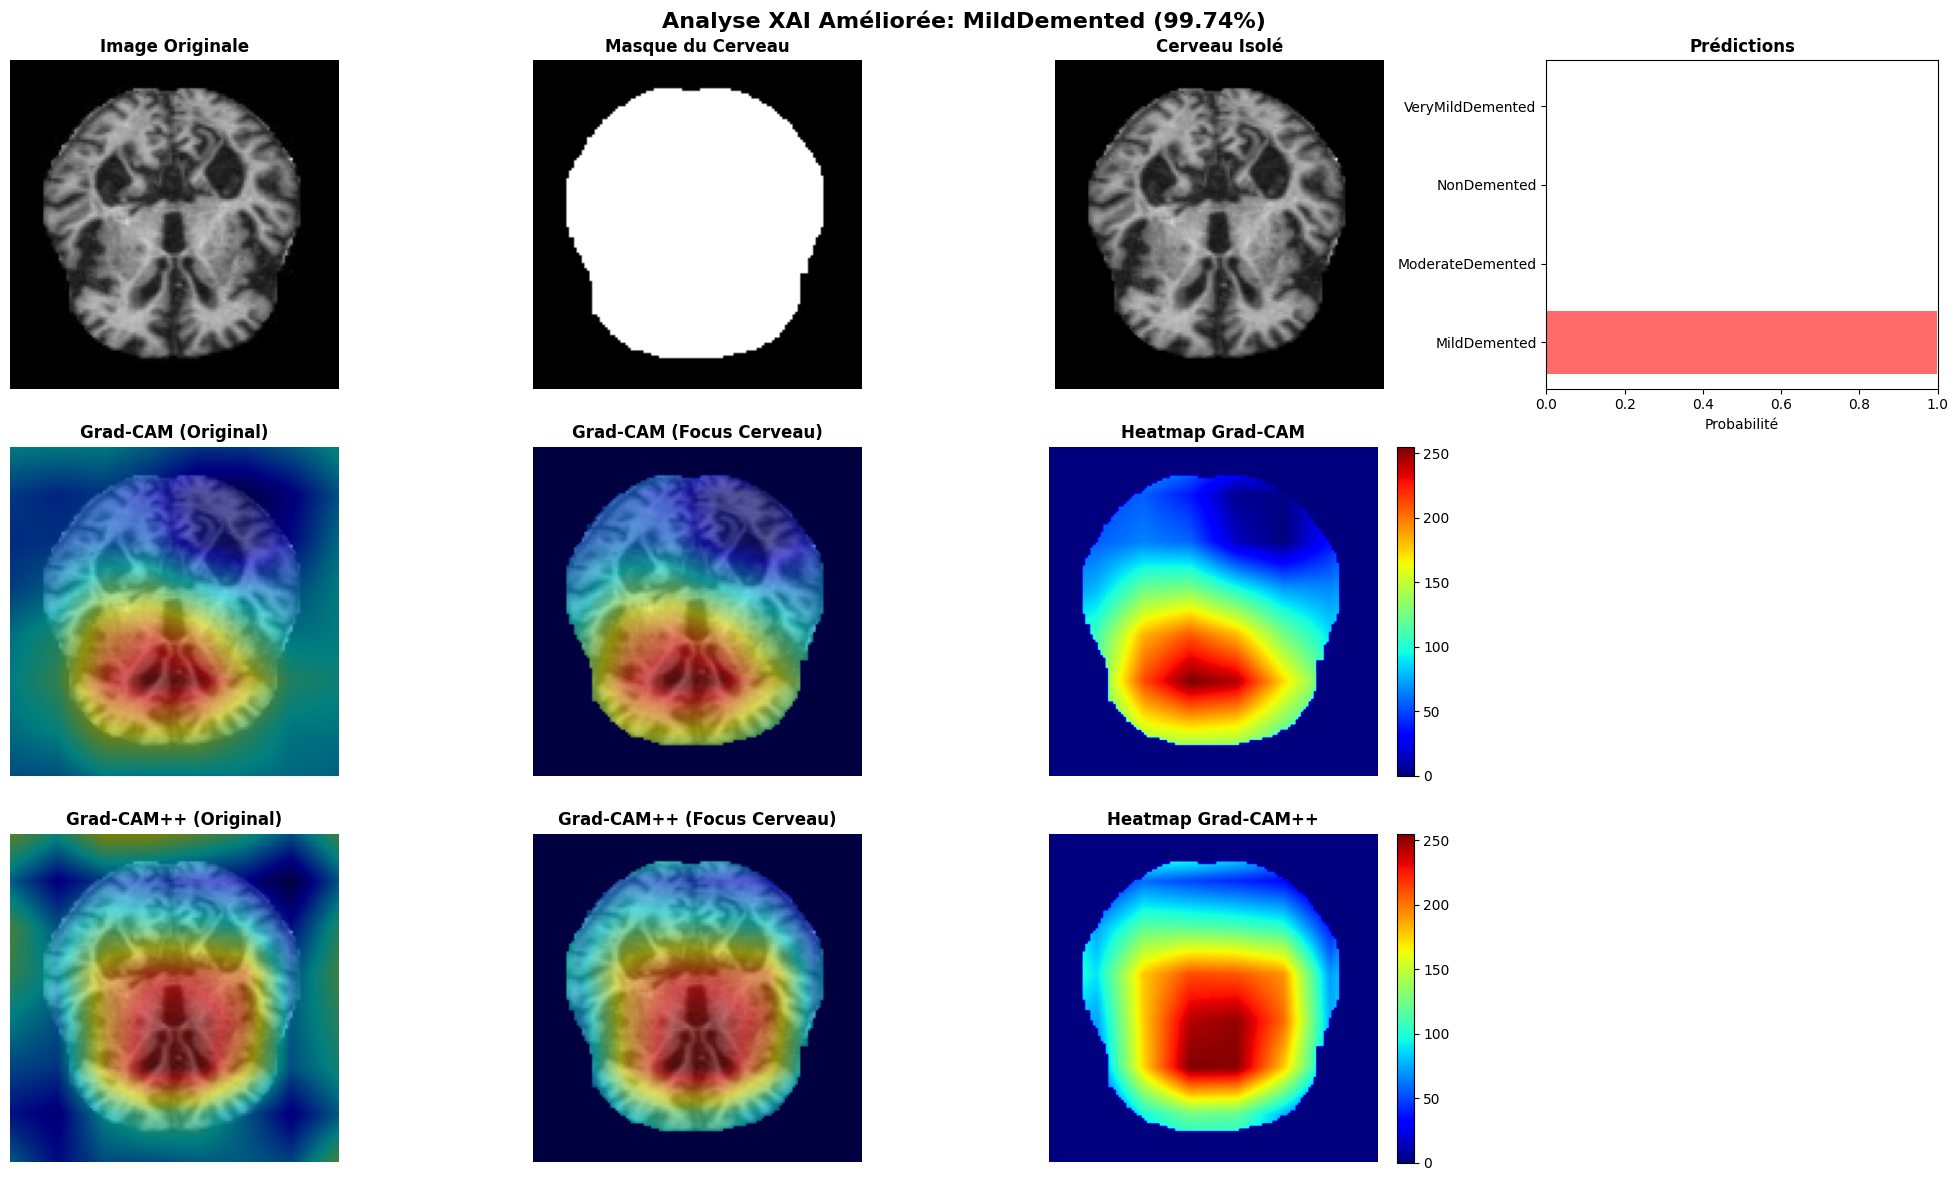


✓ Analyse terminée!

📈 ANALYSE QUANTITATIVE:
  • Pourcentage du cerveau dans l'image: 51.7%
  • Attention du modèle sur le cerveau: 60.0%
  • Attention du modèle hors cerveau: 40.0%

──────────────────────────────────────────────────────────────────────
Classe: ModerateDemented
──────────────────────────────────────────────────────────────────────

ANALYSE XAI: moderateDem28.jpg

📊 PRÉDICTION:
  • Classe: ModerateDemented
  • Confiance: 100.00%

  Probabilités:
    MildDemented: 0.00%
    ModerateDemented: 100.00%
    NonDemented: 0.00%
    VeryMildDemented: 0.00%

🔍 APPLICATION XAI:

1. Grad-CAM...
  → Couche: block5_conv3

2. Grad-CAM++...
  → Couche: block5_conv3


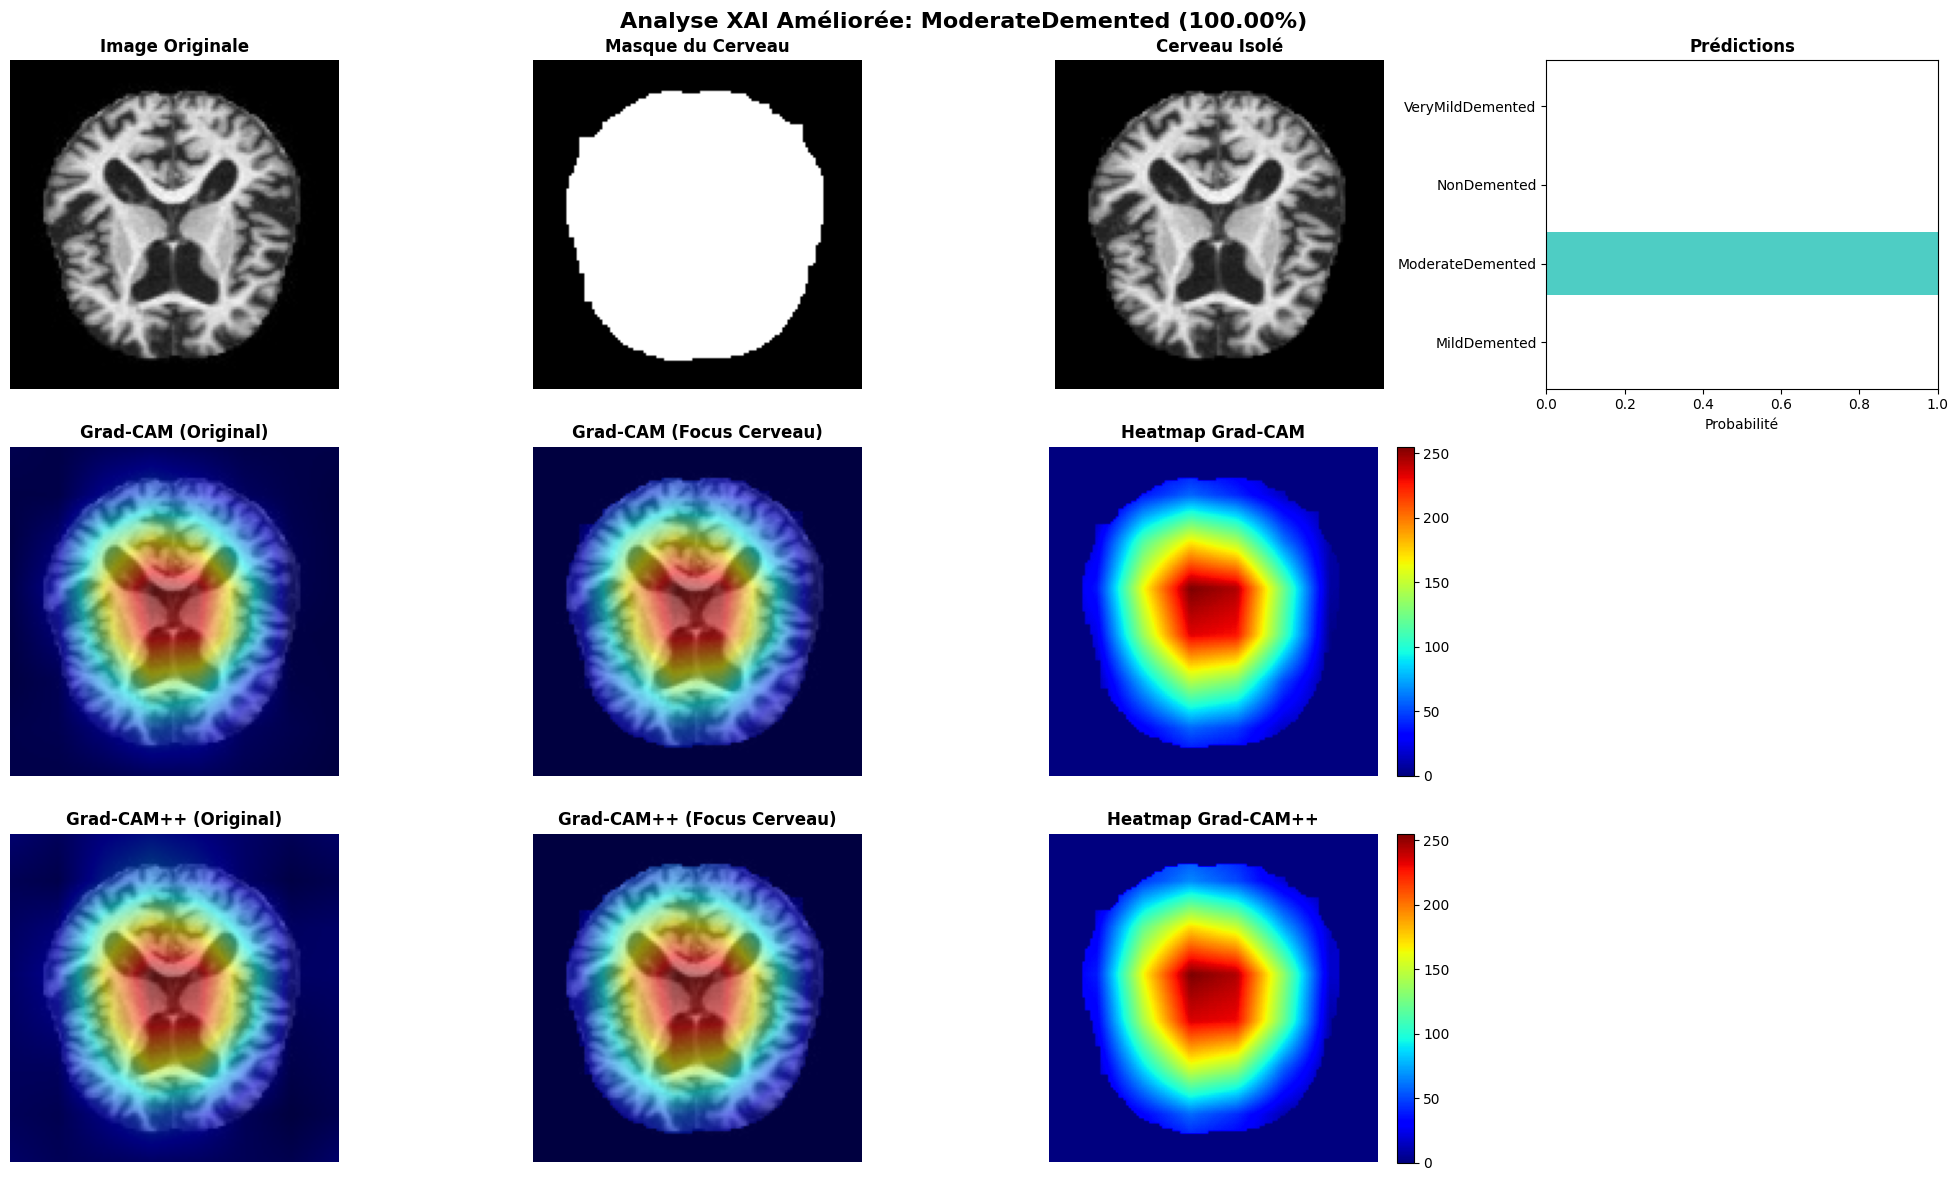


✓ Analyse terminée!

📈 ANALYSE QUANTITATIVE:
  • Pourcentage du cerveau dans l'image: 51.9%
  • Attention du modèle sur le cerveau: 91.4%
  • Attention du modèle hors cerveau: 8.6%

──────────────────────────────────────────────────────────────────────
Classe: NonDemented
──────────────────────────────────────────────────────────────────────

ANALYSE XAI: nonDem278.jpg

📊 PRÉDICTION:
  • Classe: NonDemented
  • Confiance: 99.95%

  Probabilités:
    MildDemented: 0.03%
    ModerateDemented: 0.01%
    NonDemented: 99.95%
    VeryMildDemented: 0.01%

🔍 APPLICATION XAI:

1. Grad-CAM...
  → Couche: block5_conv3

2. Grad-CAM++...
  → Couche: block5_conv3


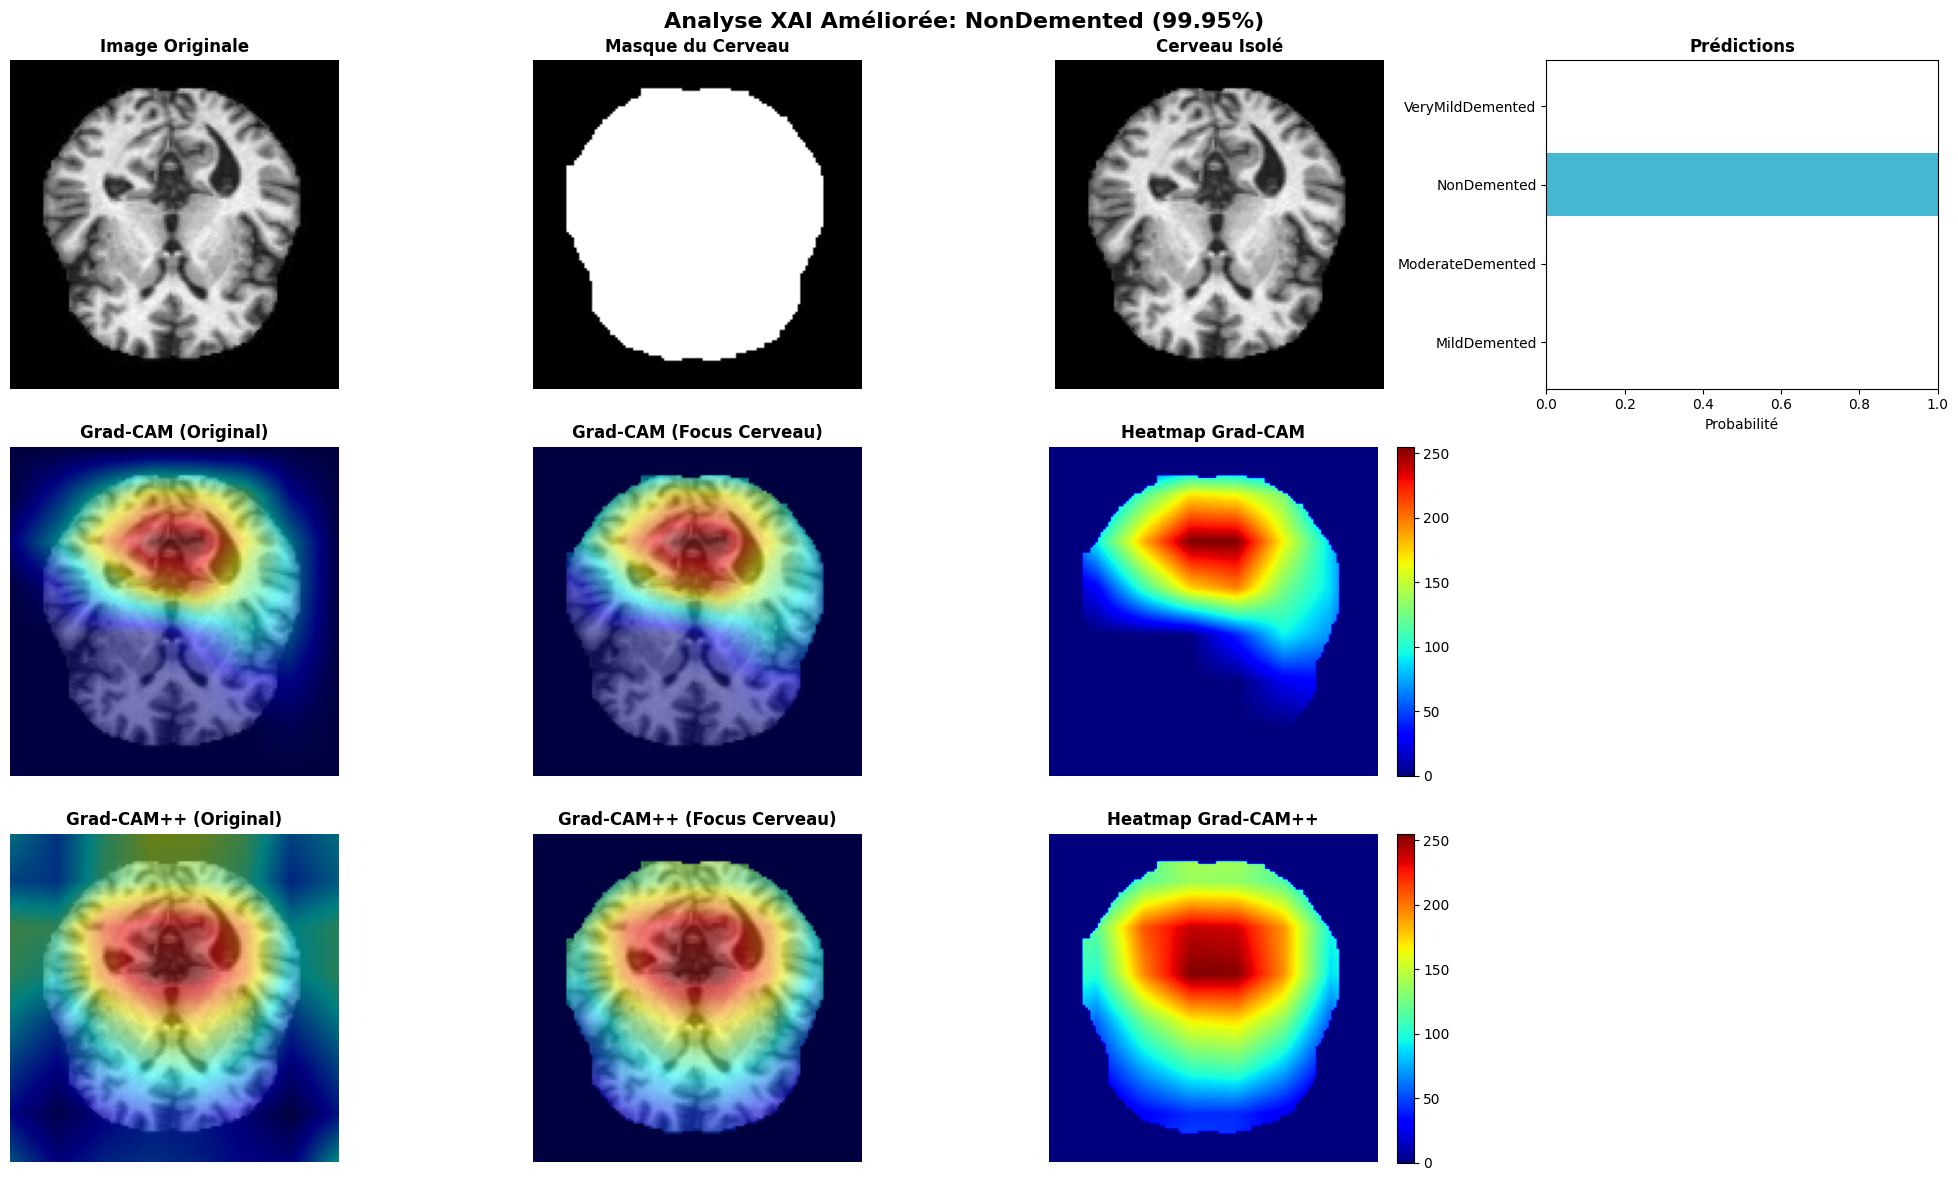


✓ Analyse terminée!

📈 ANALYSE QUANTITATIVE:
  • Pourcentage du cerveau dans l'image: 51.9%
  • Attention du modèle sur le cerveau: 82.5%
  • Attention du modèle hors cerveau: 17.5%

──────────────────────────────────────────────────────────────────────
Classe: VeryMildDemented
──────────────────────────────────────────────────────────────────────

ANALYSE XAI: verymildDem102.jpg

📊 PRÉDICTION:
  • Classe: VeryMildDemented
  • Confiance: 100.00%

  Probabilités:
    MildDemented: 0.00%
    ModerateDemented: 0.00%
    NonDemented: 0.00%
    VeryMildDemented: 100.00%

🔍 APPLICATION XAI:

1. Grad-CAM...
  → Couche: block5_conv3

2. Grad-CAM++...
  → Couche: block5_conv3


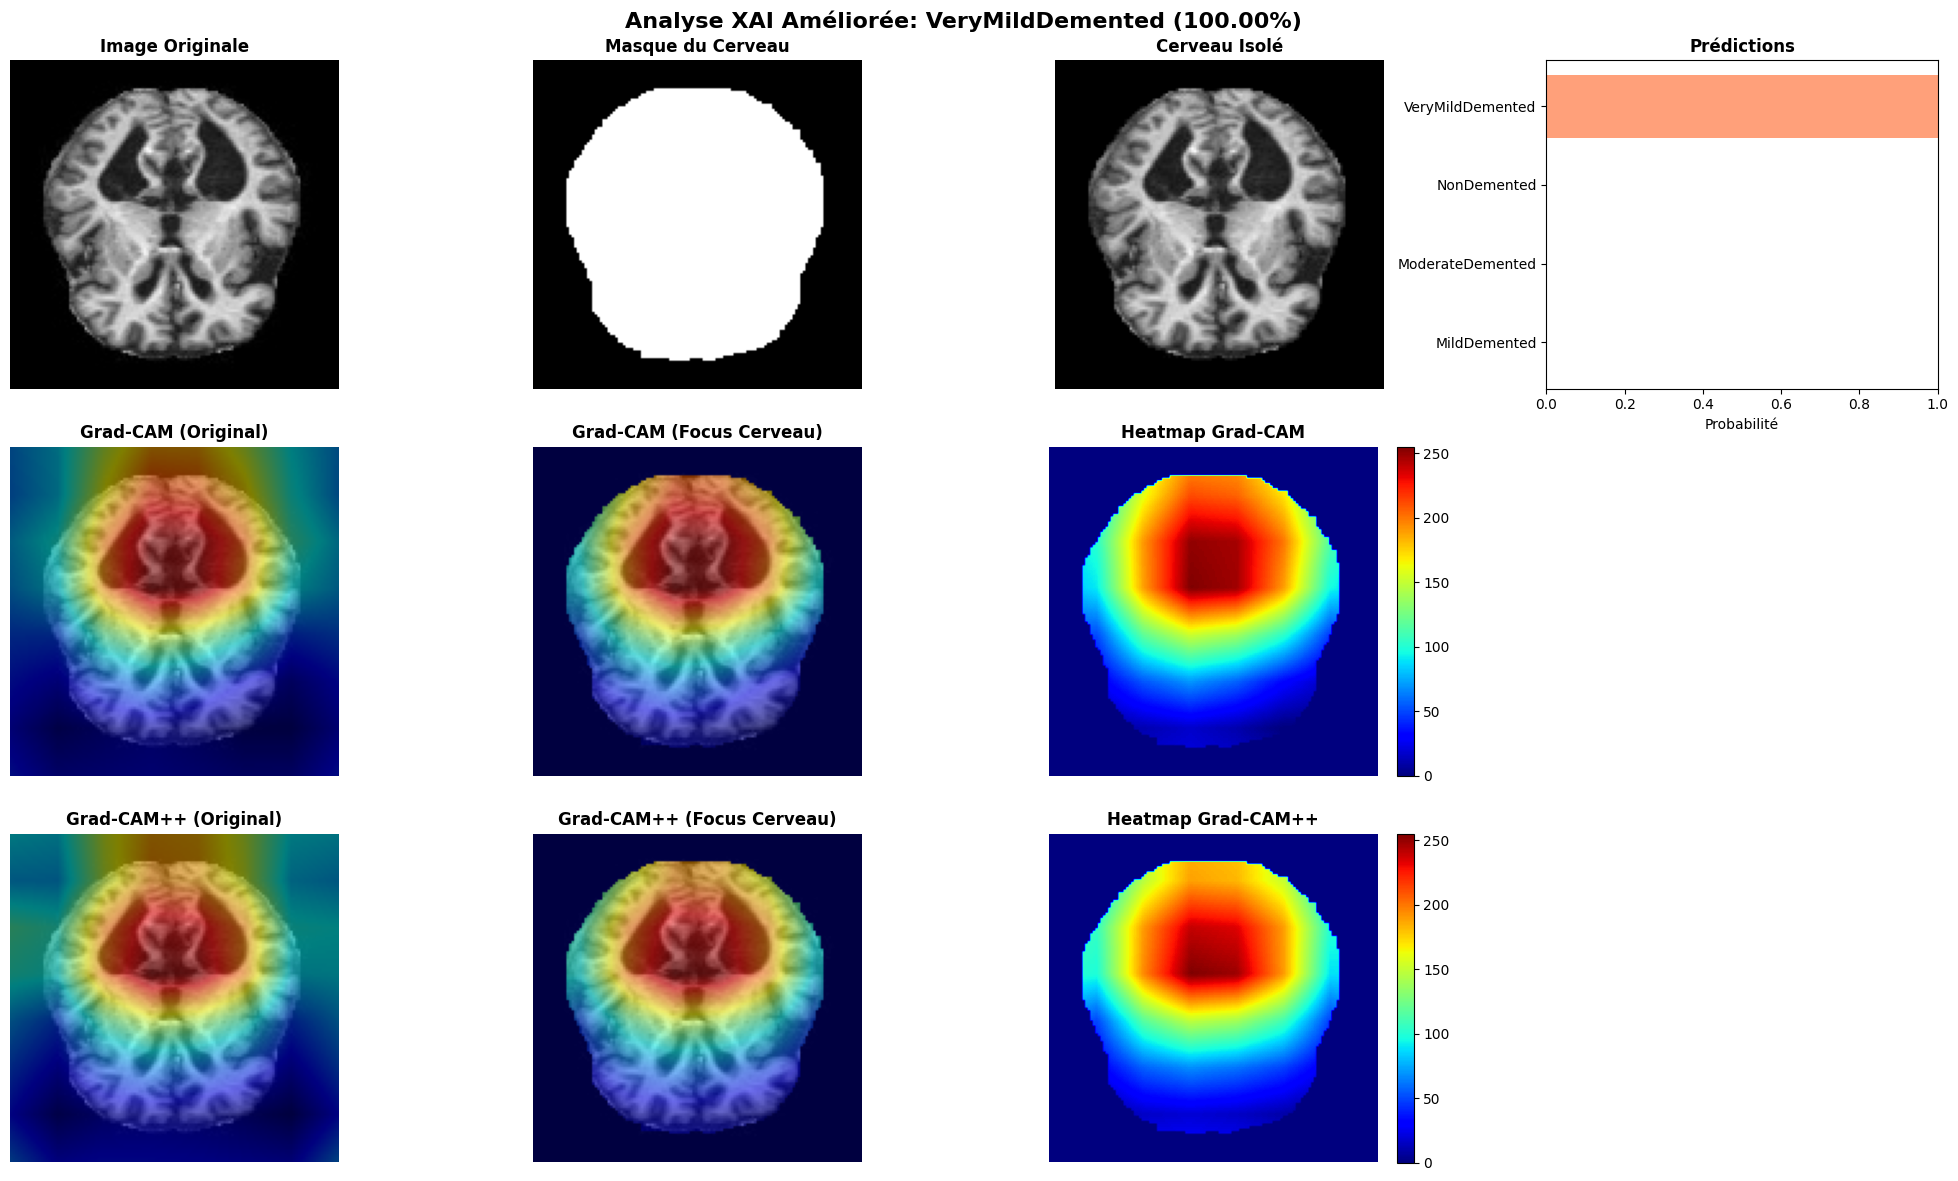


✓ Analyse terminée!

📈 ANALYSE QUANTITATIVE:
  • Pourcentage du cerveau dans l'image: 51.9%
  • Attention du modèle sur le cerveau: 68.7%
  • Attention du modèle hors cerveau: 31.3%

💡 SUGGESTIONS POUR AMÉLIORER LE MODÈLE

1. PREPROCESSING AMÉLIORÉ:
   • Recadrer les images pour centrer le cerveau
   • Supprimer le fond noir
   • Normaliser l'intensité du cerveau
   • Augmentation de données ciblée sur le cerveau

2. ARCHITECTURE:
   • Utiliser l'attention spatiale (Attention mechanisms)
   • Ajouter des skip connections
   • Utiliser des modèles pré-entraînés sur ImageNet puis fine-tuner

3. RÉGULARISATION:
   • Augmenter le dropout
   • Utiliser des pénalités L1/L2
   • Data augmentation plus agressive

4. ENTRAÎNEMENT:
   • Class weights pour gérer le déséquilibre
   • Focal loss au lieu de categorical crossentropy
   • Learning rate scheduling

5. VALIDATION:
   • Validation croisée stratifiée
   • Analyser les erreurs sur chaque classe
   • Utiliser des métriques cliniquement per

In [110]:
# ============================================================================
# XAI AMÉLIORÉ - FOCUS SUR LE CERVEAU (ALZHEIMER MRI)
# ============================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import tf_keras_vis
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Configuration
MODEL_PATH = '/kaggle/working/best_model_VGG16.h5'
DATA_PATH = '/kaggle/working/new_data/test'
IMG_SIZE = (128, 128)
CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

print("="*70)
print("CHARGEMENT DU MODÈLE")
print("="*70)
model = keras.models.load_model(MODEL_PATH)
print(f"✓ Modèle chargé")

# ============================================================================
# PREPROCESSING AMÉLIORÉ AVEC MASQUE DU CERVEAU
# ============================================================================

def extract_brain_mask(img_array):
    """Extrait un masque approximatif du cerveau (zones non-noires)"""
    # Convertir en niveaux de gris
    if len(img_array.shape) == 3:
        gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_array
    
    # Seuillage pour détecter le cerveau (zones > 10 intensité)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    
    # Opérations morphologiques pour nettoyer le masque
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask.astype(float) / 255.0

def load_and_preprocess_image(img_path, target_size=IMG_SIZE):
    """Charge et prétraite une image"""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_normalized = img_array / 255.0
    img_array_batch = np.expand_dims(img_array_normalized, axis=0)
    return img, img_array, img_array_batch

def predict_image(model, img_array, class_names):
    """Fait une prédiction sur une image"""
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    return predicted_class_idx, confidence, predictions[0]

# ============================================================================
# FONCTIONS XAI AMÉLIORÉES
# ============================================================================

def find_last_conv_layer(model):
    """Trouve la dernière couche de convolution"""
    for layer in reversed(model.layers):
        if hasattr(layer, 'output_shape'):
            output_shape = layer.output_shape
            if isinstance(output_shape, tuple) and len(output_shape) == 4:
                return layer.name
        elif 'conv' in layer.__class__.__name__.lower():
            return layer.name
    
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    
    return None

def apply_gradcam_improved(model, img_array, class_idx, layer_name=None):
    """Applique Grad-CAM amélioré"""
    if layer_name is None:
        layer_name = find_last_conv_layer(model)
    
    print(f"  → Couche: {layer_name}")
    
    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m
    
    gradcam = Gradcam(model, model_modifier=model_modifier, clone=True)
    cam = gradcam(CategoricalScore(class_idx), img_array, penultimate_layer=layer_name)
    
    return cam[0]

def apply_gradcam_plusplus_improved(model, img_array, class_idx, layer_name=None):
    """Applique Grad-CAM++ amélioré"""
    if layer_name is None:
        layer_name = find_last_conv_layer(model)
    
    print(f"  → Couche: {layer_name}")
    
    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m
    
    gradcam_pp = GradcamPlusPlus(model, model_modifier=model_modifier, clone=True)
    cam = gradcam_pp(CategoricalScore(class_idx), img_array, penultimate_layer=layer_name)
    
    return cam[0]

# ============================================================================
# VISUALISATION AMÉLIORÉE AVEC MASQUE
# ============================================================================

def overlay_heatmap_with_mask(img, heatmap, brain_mask=None, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """Superpose la heatmap sur l'image avec focus sur le cerveau"""
    # Convertir PIL Image en numpy array si nécessaire
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    
    # Redimensionner la heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Appliquer le masque du cerveau si fourni
    if brain_mask is not None:
        brain_mask_resized = cv2.resize(brain_mask, (img.shape[1], img.shape[0]))
        # Réduire fortement l'intensité hors du cerveau
        heatmap = heatmap * brain_mask_resized
    
    # Normaliser la heatmap APRÈS le masquage
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()
    
    # Convertir en uint8
    heatmap = np.uint8(255 * heatmap)
    
    # Appliquer la colormap
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Superposer
    superimposed = heatmap_colored * alpha + img * (1 - alpha)
    superimposed = np.uint8(superimposed)
    
    return superimposed, heatmap

def visualize_xai_brain_focused(model, img_path, class_names):
    """Visualise XAI avec focus sur le cerveau"""
    print(f"\n{'='*70}")
    print(f"ANALYSE XAI: {os.path.basename(img_path)}")
    print(f"{'='*70}")
    
    # Charger l'image
    img, img_array, img_array_batch = load_and_preprocess_image(img_path)
    
    # Extraire le masque du cerveau
    brain_mask = extract_brain_mask(img_array)
    
    # Prédiction
    pred_idx, confidence, all_preds = predict_image(model, img_array_batch, class_names)
    pred_class = class_names[pred_idx]
    
    print(f"\n📊 PRÉDICTION:")
    print(f"  • Classe: {pred_class}")
    print(f"  • Confiance: {confidence:.2%}")
    print(f"\n  Probabilités:")
    for i in range(len(class_names)):
        print(f"    {class_names[i]}: {all_preds[i]:.2%}")
    
    # Appliquer XAI
    print(f"\n🔍 APPLICATION XAI:")
    
    print("\n1. Grad-CAM...")
    gradcam_heatmap = apply_gradcam_improved(model, img_array_batch, pred_idx)
    
    print("\n2. Grad-CAM++...")
    gradcam_pp_heatmap = apply_gradcam_plusplus_improved(model, img_array_batch, pred_idx)
    
    # Créer les overlays avec et sans masque
    gradcam_overlay_nomask, _ = overlay_heatmap_with_mask(img, gradcam_heatmap, brain_mask=None, alpha=0.5)
    gradcam_overlay_masked, gradcam_masked = overlay_heatmap_with_mask(img, gradcam_heatmap, brain_mask=brain_mask, alpha=0.5)
    
    gradcam_pp_overlay_nomask, _ = overlay_heatmap_with_mask(img, gradcam_pp_heatmap, brain_mask=None, alpha=0.5)
    gradcam_pp_overlay_masked, gradcam_pp_masked = overlay_heatmap_with_mask(img, gradcam_pp_heatmap, brain_mask=brain_mask, alpha=0.5)
    
    # Visualisation comparative
    fig = plt.figure(figsize=(20, 12))
    
    # Ligne 1: Image originale + masque + prédictions
    ax1 = plt.subplot(3, 4, 1)
    ax1.imshow(img)
    ax1.set_title('Image Originale', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    ax2 = plt.subplot(3, 4, 2)
    ax2.imshow(brain_mask, cmap='gray')
    ax2.set_title('Masque du Cerveau', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    ax3 = plt.subplot(3, 4, 3)
    img_masked = np.array(img) * brain_mask[:,:,np.newaxis]
    ax3.imshow(img_masked.astype(np.uint8))
    ax3.set_title('Cerveau Isolé', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    ax4 = plt.subplot(3, 4, 4)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    ax4.barh(class_names, all_preds, color=colors)
    ax4.set_xlabel('Probabilité', fontsize=10)
    ax4.set_title('Prédictions', fontsize=12, fontweight='bold')
    ax4.set_xlim([0, 1])
    
    # Ligne 2: Grad-CAM (sans masque vs avec masque)
    ax5 = plt.subplot(3, 4, 5)
    ax5.imshow(gradcam_overlay_nomask)
    ax5.set_title('Grad-CAM (Original)', fontsize=12, fontweight='bold')
    ax5.axis('off')
    
    ax6 = plt.subplot(3, 4, 6)
    ax6.imshow(gradcam_overlay_masked)
    ax6.set_title('Grad-CAM (Focus Cerveau)', fontsize=12, fontweight='bold')
    ax6.axis('off')
    
    ax7 = plt.subplot(3, 4, 7)
    ax7.imshow(gradcam_masked, cmap='jet')
    ax7.set_title('Heatmap Grad-CAM', fontsize=12, fontweight='bold')
    ax7.axis('off')
    plt.colorbar(ax7.imshow(gradcam_masked, cmap='jet'), ax=ax7, fraction=0.046)
    
    # Ligne 3: Grad-CAM++ (sans masque vs avec masque)
    ax9 = plt.subplot(3, 4, 9)
    ax9.imshow(gradcam_pp_overlay_nomask)
    ax9.set_title('Grad-CAM++ (Original)', fontsize=12, fontweight='bold')
    ax9.axis('off')
    
    ax10 = plt.subplot(3, 4, 10)
    ax10.imshow(gradcam_pp_overlay_masked)
    ax10.set_title('Grad-CAM++ (Focus Cerveau)', fontsize=12, fontweight='bold')
    ax10.axis('off')
    
    ax11 = plt.subplot(3, 4, 11)
    ax11.imshow(gradcam_pp_masked, cmap='jet')
    ax11.set_title('Heatmap Grad-CAM++', fontsize=12, fontweight='bold')
    ax11.axis('off')
    plt.colorbar(ax11.imshow(gradcam_pp_masked, cmap='jet'), ax=ax11, fraction=0.046)
    
    fig.suptitle(f'Analyse XAI Améliorée: {pred_class} ({confidence:.2%})', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.savefig(f'xai_brain_focused_{os.path.basename(img_path)}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Analyse terminée!")
    
    # Analyse quantitative
    print(f"\n📈 ANALYSE QUANTITATIVE:")
    print(f"  • Pourcentage du cerveau dans l'image: {(brain_mask.mean() * 100):.1f}%")
    
    # Calculer où se concentre l'attention
    total_attention_original = gradcam_heatmap.sum()
    total_attention_brain = (gradcam_heatmap * brain_mask).sum()
    brain_attention_ratio = (total_attention_brain / total_attention_original * 100) if total_attention_original > 0 else 0
    
    print(f"  • Attention du modèle sur le cerveau: {brain_attention_ratio:.1f}%")
    print(f"  • Attention du modèle hors cerveau: {(100-brain_attention_ratio):.1f}%")
    
    if brain_attention_ratio < 50:
        print(f"\n⚠️  ATTENTION: Le modèle se concentre principalement HORS du cerveau!")
        print(f"     → Cela suggère que le modèle a appris des patterns non pertinents")
        print(f"     → Considérez un réentraînement avec preprocessing amélioré")

# ============================================================================
# SUGGESTIONS D'AMÉLIORATION DU MODÈLE
# ============================================================================

def print_improvement_suggestions():
    """Affiche des suggestions pour améliorer le modèle"""
    print("\n" + "="*70)
    print("💡 SUGGESTIONS POUR AMÉLIORER LE MODÈLE")
    print("="*70)
    print("""
1. PREPROCESSING AMÉLIORÉ:
   • Recadrer les images pour centrer le cerveau
   • Supprimer le fond noir
   • Normaliser l'intensité du cerveau
   • Augmentation de données ciblée sur le cerveau

2. ARCHITECTURE:
   • Utiliser l'attention spatiale (Attention mechanisms)
   • Ajouter des skip connections
   • Utiliser des modèles pré-entraînés sur ImageNet puis fine-tuner

3. RÉGULARISATION:
   • Augmenter le dropout
   • Utiliser des pénalités L1/L2
   • Data augmentation plus agressive

4. ENTRAÎNEMENT:
   • Class weights pour gérer le déséquilibre
   • Focal loss au lieu de categorical crossentropy
   • Learning rate scheduling

5. VALIDATION:
   • Validation croisée stratifiée
   • Analyser les erreurs sur chaque classe
   • Utiliser des métriques cliniquement pertinentes
    """)

# ============================================================================
# EXÉCUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("ANALYSE XAI AVEC FOCUS SUR LE CERVEAU")
    print("="*70)
    
    # Trouver des images
    sample_images = {}
    for class_name in CLASS_NAMES:
        class_path = os.path.join(DATA_PATH, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if images:
                sample_images[class_name] = [os.path.join(class_path, img) for img in images[:2]]
    
    if sample_images:
        # Analyser une image de chaque classe
        for class_name, img_paths in sample_images.items():
            print(f"\n{'─'*70}")
            print(f"Classe: {class_name}")
            print(f"{'─'*70}")
            visualize_xai_brain_focused(model, img_paths[0], CLASS_NAMES)
        
        # Afficher les suggestions
        print_improvement_suggestions()
    else:
        print("❌ Aucune image trouvée")
    
    print("\n" + "="*70)
    print("✓ ANALYSE TERMINÉE")
    print("="*70)

In [109]:
# Réinitialiser les fonctions built-in écrasées
import builtins
zip = builtins.zip

In [108]:
! pip install tf_keras_vis

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Dossier de validation pour une classe
class_dir = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val/NonDemented"

# Lister les images existantes
images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

print("Nombre d’images trouvées :", len(images))
print("Exemple d’images :", images[:5])

# Prendre la première image
img_path = os.path.join(class_dir, images[0])
print("Image utilisée :", img_path)

# Charger et prétraiter
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array_norm = img_array / 255.0

# Extraire le masque du cerveau
brain_mask = extract_brain_mask(img_array)

# Appliquer le masque
img_brain_only = img_array_norm * brain_mask[:, :, np.newaxis]
img_brain_only = np.expand_dims(img_brain_only, axis=0)

# Prédiction
pred_idx_masked, conf_masked, _ = predict_image(model, img_brain_only, CLASS_NAMES)

print("\n🧪 TEST CERVEAU SEUL")
print("Classe prédite :", CLASS_NAMES[pred_idx_masked])
print("Confiance :", f"{conf_masked:.2%}")


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# 1️⃣ Choisir une image existante automatiquement
class_dir = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val/NonDemented"
images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
img_path = os.path.join(class_dir, images[0])

# 2️⃣ Charger l’image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array_norm = img_array / 255.0
img_array_batch = np.expand_dims(img_array_norm, axis=0)

# 3️⃣ Masque du cerveau
brain_mask = extract_brain_mask(img_array)

# 4️⃣ Prédiction
pred_idx, confidence, _ = predict_image(model, img_array_batch, CLASS_NAMES)
print("Classe prédite :", CLASS_NAMES[pred_idx])
print("Confiance :", f"{confidence:.2%}")

# 5️⃣ Grad-CAM (IMPORTANT)
gradcam_heatmap = apply_gradcam_improved(
    model,
    img_array_batch,
    pred_idx
)

# 6️⃣ Calcul du ratio d’attention cerveau
brain_attention = (gradcam_heatmap * brain_mask).sum()
total_attention = gradcam_heatmap.sum()

ratio = brain_attention / total_attention if total_attention > 0 else 0

print("\n📊 ANALYSE ATTENTION")
print(f"Attention cerveau : {ratio * 100:.1f}%")
print(f"Attention hors cerveau : {(1 - ratio) * 100:.1f}%")


In [ ]:
model.summary()


In [ ]:
layer_name = "conv2d_3"  # exemple
gradcam_heatmap = apply_gradcam_improved(model, img_array_batch, pred_idx, layer_name)


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore


In [ ]:
# Chemins
MODEL_PATH = "/kaggle/working/best_model.h5"
DATA_DIR = "/kaggle/working/new_data/test"
IMG_SIZE = (128, 128)

CLASS_NAMES = [
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented"
]

# Charger le modèle
model = keras.models.load_model(MODEL_PATH)
print("✓ Modèle chargé")


In [ ]:
def extract_brain_mask(img_array):
    """Masque approximatif du cerveau (zones non noires)"""
    gray = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask / 255.0


In [ ]:
def load_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_norm = img_array / 255.0
    return img, img_array, np.expand_dims(img_norm, axis=0)


In [ ]:
def predict_image(model, img_batch):
    preds = model.predict(img_batch, verbose=0)[0]
    idx = np.argmax(preds)
    return idx, preds[idx], preds


In [ ]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None


In [ ]:
def apply_gradcam(model, img_batch, class_idx):
    layer_name = find_last_conv_layer(model)
    print("Couche Grad-CAM :", layer_name)

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    gradcam = Gradcam(model, model_modifier=model_modifier, clone=True)
    cam = gradcam(CategoricalScore(class_idx), img_batch, penultimate_layer=layer_name)
    return cam[0]


In [ ]:
def overlay_heatmap(img, heatmap, mask=None, alpha=0.5):
    img = np.array(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    if mask is not None:
        heatmap = heatmap * cv2.resize(mask, (img.shape[1], img.shape[0]))

    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    return np.uint8(img * (1 - alpha) + heatmap * alpha)


In [ ]:
def run_xai_on_image(img_path):
    print("\n" + "="*60)
    print("IMAGE :", os.path.basename(img_path))
    print("="*60)

    # Charger image
    img, img_array, img_batch = load_image(img_path)

    # Masque cerveau
    brain_mask = extract_brain_mask(img_array)

    # Prédiction normale
    pred_idx, conf, preds = predict_image(model, img_batch)
    print("Classe prédite :", CLASS_NAMES[pred_idx])
    print("Confiance :", f"{conf:.2%}")

    # Grad-CAM
    gradcam_heatmap = apply_gradcam(model, img_batch, pred_idx)

    # Ratio attention cerveau
    brain_attention = (gradcam_heatmap * brain_mask).sum()
    total_attention = gradcam_heatmap.sum()
    ratio = brain_attention / total_attention if total_attention > 0 else 0

    print(f"Attention cerveau : {ratio*100:.1f}%")
    print(f"Attention hors cerveau : {(1-ratio)*100:.1f}%")

    # Test cerveau seul
    img_brain_only = (img_array / 255.0) * brain_mask[:, :, np.newaxis]
    img_brain_only = np.expand_dims(img_brain_only, axis=0)

    pred_idx_masked, conf_masked, _ = predict_image(model, img_brain_only)
    print("\n🧪 Test cerveau seul")
    print("Classe :", CLASS_NAMES[pred_idx_masked])
    print("Confiance :", f"{conf_masked:.2%}")

    # Visualisation
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(img)
    axs[0].set_title("Image originale")
    axs[0].axis("off")

    axs[1].imshow(brain_mask, cmap="gray")
    axs[1].set_title("Masque cerveau")
    axs[1].axis("off")

    axs[2].imshow(overlay_heatmap(img, gradcam_heatmap))
    axs[2].set_title("Grad-CAM (global)")
    axs[2].axis("off")

    axs[3].imshow(overlay_heatmap(img, gradcam_heatmap, brain_mask))
    axs[3].set_title("Grad-CAM (focus cerveau)")
    axs[3].axis("off")

    plt.show()

    return ratio


In [ ]:
# Choisir une image automatiquement
class_dir = os.path.join(DATA_DIR, "NonDemented")
img_name = os.listdir(class_dir)[0]
img_path = os.path.join(class_dir, img_name)

ratio = run_xai_on_image(img_path)


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore


In [ ]:
MODEL_PATH = "/kaggle/working/best_model.h5"
DATA_DIR = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val"
IMG_SIZE = (128, 128)

CLASS_NAMES = [
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented"
]

model = keras.models.load_model(MODEL_PATH)
print("✓ Modèle chargé")


In [ ]:
def load_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_norm = img_array / 255.0
    return img, img_array, np.expand_dims(img_norm, axis=0)


In [ ]:
def extract_brain_mask(img_array):
    gray = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask / 255.0


In [ ]:
def predict_image(model, img_batch):
    preds = model.predict(img_batch, verbose=0)[0]
    idx = np.argmax(preds)
    return idx, preds[idx], preds


In [ ]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None


In [ ]:
def apply_gradcam(model, img_batch, class_idx, layer_name=None):
    if layer_name is None:
        layer_name = find_last_conv_layer(model)

    print("Couche Grad-CAM :", layer_name)

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    gradcam = Gradcam(model, model_modifier=model_modifier, clone=True)
    cam = gradcam(
        CategoricalScore(class_idx),
        img_batch,
        penultimate_layer=layer_name
    )

    return cam[0]


In [ ]:
def overlay_heatmap(img, heatmap, mask=None, alpha=0.5):
    img = np.array(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    if mask is not None:
        heatmap = heatmap * cv2.resize(mask, (img.shape[1], img.shape[0]))

    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    return np.uint8(img * (1 - alpha) + heatmap * alpha)


In [ ]:
def run_xai(img_path, layer_name=None):
    print("\n" + "="*60)
    print("IMAGE :", os.path.basename(img_path))
    print("="*60)

    # Charger image
    img, img_array, img_batch = load_image(img_path)

    # Masque cerveau
    brain_mask = extract_brain_mask(img_array)

    # Prédiction normale
    pred_idx, conf, preds = predict_image(model, img_batch)
    print("Classe prédite :", CLASS_NAMES[pred_idx])
    print("Confiance :", f"{conf:.2%}")

    # Grad-CAM
    gradcam_heatmap = apply_gradcam(model, img_batch, pred_idx, layer_name)

    # Ratio attention cerveau
    brain_attention = (gradcam_heatmap * brain_mask).sum()
    total_attention = gradcam_heatmap.sum()
    ratio = brain_attention / total_attention if total_attention > 0 else 0

    print(f"Attention cerveau : {ratio*100:.1f}%")
    print(f"Attention hors cerveau : {(1-ratio)*100:.1f}%")

    # Test cerveau seul
    img_brain_only = (img_array / 255.0) * brain_mask[:, :, np.newaxis]
    img_brain_only = np.expand_dims(img_brain_only, axis=0)

    pred_idx_masked, conf_masked, _ = predict_image(model, img_brain_only)
    print("\n🧪 Test cerveau seul")
    print("Classe :", CLASS_NAMES[pred_idx_masked])
    print("Confiance :", f"{conf_masked:.2%}")

    # Visualisation
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(img)
    axs[0].set_title("Image originale")
    axs[0].axis("off")

    axs[1].imshow(brain_mask, cmap="gray")
    axs[1].set_title("Masque cerveau")
    axs[1].axis("off")

    axs[2].imshow(overlay_heatmap(img, gradcam_heatmap))
    axs[2].set_title("Grad-CAM global")
    axs[2].axis("off")

    axs[3].imshow(overlay_heatmap(img, gradcam_heatmap, brain_mask))
    axs[3].set_title("Grad-CAM focus cerveau")
    axs[3].axis("off")

    plt.show()

    return ratio


In [ ]:
# Choisir une image automatiquement
class_dir = os.path.join(DATA_DIR, "NonDemented")
img_name = [f for f in os.listdir(class_dir) if f.endswith(('.jpg','.png'))][0]
img_path = os.path.join(class_dir, img_name)

# Tester différentes couches si tu veux
run_xai(img_path, layer_name=None)        # dernière conv
# run_xai(img_path, layer_name="conv2d_2")  # couche intermédiaire
